# 1.Making a car classifier using Pytorch

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

It is difficult to directly train deep learning model on this dataset because the limited number of images. Thus we decide to use transfer learning, a common approch used in deep learning to utilize the pretrained model on [imagenet](http://www.image-net.org/) and fine-tune on our own dataset, i.e. car dataset.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

## 1.1 Transfer Learning
Transfer learning is one of the most widely used technologies in deep learning and computer vision. 

For traditional ML, it's about isolated and single task learning: knowledge is not retained or accumulated. Learning is performed w.o. considering past learned knowledge in other tasks.

While for transfer learning, learning of a new tasks reles on the previous learned tasks: learning process can be faster, more accurate and need less training data.

# 2.Data

In this notebook we are making a car classifier using the Stanford car dataset, which contains 196 classes.
We'll be using a pre-trained model with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

# 3. Preparation

## 3.1 Load packages

The pytorch have been pre-installled on colab, and we do not need re-install these packages.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")  # Default CUDA device
    print("CUDA is available. Using GPU.")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Print the name of the GPU
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

print("PyTorch version:", torch.__version__)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import svm

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce GTX 1080 Ti


## 3.2 Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 224x224 images (you can also change the resolution) with random horizontal flip, random rotation and normalization

In [18]:
dataset_dir = "car_data/car_data/"

# data transformation, can try different transformation/ data augmentation here
# RandomCrop and HorizontalFlip
# note: no data augmentation for test data

width, height = 224, 224
NUM_CAR_CLASSES = 196

train_tfms = transforms.Compose([
#                                  transforms.RandomResizedCrop(299),
#                                  transforms.RandomHorizontalFlip(),
#                                  transforms.RandomRotation(15),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
#                                  transforms.Resize((width, height)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                                      std=[0.229, 0.224, 0.225])])
                                 # mean and std from imagenet dataset


test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                                     std=[0.229, 0.224, 0.225])])


# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)

## 3.3 Model training and evaluation function

In [19]:
########################### Method 1 functions

# Here we train our model, after each epoch, we test the model on the test data to see how it's going
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):

    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()

    for epoch in tqdm.tqdm(range(n_epochs)): # adding progress bars to Python loops
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for _, data in enumerate(trainloader, 0): # start=0
        # trainloader: {[index, (inputs of a batch, labels)]}

            # get the inputs and assign them to cuda
            inputs, labels = data # input is a batch
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)

            # uncomment for half precision model
            # with torch.cuda.amp.autocast():
            #     outputs = model(inputs)

            # forward pass
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # zero the gradient
            optimizer.zero_grad()

            # backpropagation
            loss.backward()

            # update parameters
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % \
                 (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc,_,_ = eval_model(model)
        test_accuracies.append(test_acc)

        # re-set the model to train mode after validating
        model.train()

        # adjust the learning rate during training
        scheduler.step(test_acc)

        # since = time.time()

    print('Finished Training')
    return model, losses, accuracies, test_accuracies


# This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.
def eval_model(model):
    correct = 0.0
    total = 0.0
    
    all_preds = []
    all_labels = []
    
    # disabling gradient computation
    with torch.no_grad():
        for _, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc, all_preds, all_labels

########################### Method 2 functions

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in tqdm.tqdm(dataloader):
            # inputs will be a batch of images, eg. shape (32, 3, 224, 224)
            # label contains the corresponding labels for the images in the batch, shape (32,)
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # (32, 2048, 1, 1)->(32, 2048)
            outputs = outputs.view(outputs.size(0), -1)
            
            features.append(outputs.cpu().numpy())
            labels.append(label.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


def eval_model_extract(classifier, test_features, test_labels):
    classifier.eval()
    test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = classifier(test_features)
        _, preds = torch.max(outputs, 1)
        accuracy = torch.sum(preds == test_labels).double() / len(test_labels)

    print(f'Accuracy of the network on the test images: {accuracy:.4f}')
    return accuracy


def train_linear_classifier(train_features, train_labels, test_features, test_labels, dim):
    # Initialize lists to store loss and accuracy
    train_accs = []
    losses = []
    test_accuracies = []
    
    classifier = nn.Linear(dim, NUM_CAR_CLASSES) 
    
    classifier = classifier.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.01)
#   optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

    # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
    # mode: lr will be reduced when the test_acc has stopped increasing.
    # patience: the number of allowed epochs with no improvement after which the learning rate will be reduced.
    # threshold: threshold for measuring the new optimum, to only focus on significant changes.
    # tracking the training accuracy and measuring whether it increases by at least 0.9 per 3 epochs 
    # and if it hasn't increased by 0.9 reduce the lr by 0.1x.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

    train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)

    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    classifier.train()
    for epoch in range(20):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader:
            
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/20, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        train_accs.append(epoch_acc.item())
        losses.append(epoch_loss)
        
        # Evaluate on test set
        test_accuracy = eval_model_extract(classifier, test_features, test_labels)
        test_accuracies.append(test_accuracy.item())
        
        scheduler.step(test_accuracy)
    

    print('Finished Training')
    return classifier, losses, train_accs, test_accuracies

def train_svm_classifier(train_features, train_labels, test_features, test_labels):

    # Train SVM classifier
    classifier = svm.SVC(kernel='linear')

    # Flatten features
    train_features = train_features.reshape(train_features.shape[0], -1)
    test_features = test_features.reshape(test_features.shape[0], -1)

    # Train SVM classifier
    classifier.fit(train_features, train_labels)

    # Evaluate on train set
    train_accuracy = classifier.score(train_features, train_labels)
    print(f'Accuracy on train set: {train_accuracy:.4f}')

    # Evaluate on test set
    test_accuracy = classifier.score(test_features, test_labels)
    print(f'Accuracy on test set: {test_accuracy:.4f}')

    return classifier, train_accuracy, test_accuracy


# Combine the feature extractor and the classifier
class CombinedModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super(CombinedModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# 4.Experiment

In this part, we will basically try four different CNN models (alexnet, vgg19, resnet50 and googlenet_v3) with varying techniques. 

## Preparation

In [20]:
def feature_extraction(model_ft, dim):
    
    # Remove the last fully-connected layer
    model_ft = nn.Sequential(*list(model_ft.children())[:-1])
    model_ft = model_ft.to(device)
    
    # Extract features from train and test sets
    train_features, train_labels = extract_features(model_ft, trainloader)
    test_features, test_labels = extract_features(model_ft, testloader)

   
    # Train the linear classifier
    classifier, losses, train_accuracies, test_accuracies = \
         train_linear_classifier(train_features, train_labels, test_features, test_labels, dim)
   
    # Attach the classifier to the feature extractor
    model = CombinedModel(model_ft, classifier)
    model = model.to(device)
    
    return train_features, train_labels, test_features, test_labels, losses, train_accuracies, test_accuracies, model

In [21]:
def fine_tune_deep_alex(model_ft, layer_num):
    # Replace the last fully connected layer with an untrained one (requires grad by default)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

    # Move the model to the device
    model_ft = model_ft.to(device)

    # Freeze earlier layers (optional: fine-tune only higher layers)
    for param in model_ft.features.parameters():
        param.requires_grad = False

    # Freeze the first few layers in the classifier, typically the classifier part of AlexNet looks like this: 
    # classifier: (Dropout, Linear, ReLU, Dropout, Linear, ReLU, Linear) 
    # We only keep the last three layers trainable (i.e., the fourth, fifth, ReLU and last Linear). ReLU and the last Linear), so we freeze the previous layers
    for i, layer in enumerate(model_ft.classifier):
        if i < layer_num:
            for param in layer.parameters():
                param.requires_grad = False

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.01, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)
    
    return train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=30)

## 4.1 Alexnet

### 4.1.1 feature extractor method

In [22]:
# Import pretrained Alexnet model
model_ft = models.alexnet(weights='IMAGENET1K_V1')

# Train the linear classifier
train_features, train_labels, test_features, test_labels, losses_alex_li, train_accuracies_alex_li, test_accuracies_alex_li, model_alex_li = \
                feature_extraction(model_ft, 9216)

100%|██████████| 252/252 [00:41<00:00,  6.04it/s]


Epoch 1/20, Loss: 119.4905, Accuracy: 0.0312
Accuracy of the network on the test images: 0.0679
Epoch 2/20, Loss: 31.0714, Accuracy: 0.5011
Accuracy of the network on the test images: 0.0754
Epoch 3/20, Loss: 19.0797, Accuracy: 0.6785
Accuracy of the network on the test images: 0.0741
Epoch 4/20, Loss: 13.6498, Accuracy: 0.7596
Accuracy of the network on the test images: 0.0754
Epoch 5/20, Loss: 9.7676, Accuracy: 0.8206
Accuracy of the network on the test images: 0.0867
Epoch 6/20, Loss: 2.1064, Accuracy: 0.9478
Accuracy of the network on the test images: 0.1048
Epoch 7/20, Loss: 0.1833, Accuracy: 0.9891
Accuracy of the network on the test images: 0.1068
Epoch 8/20, Loss: 0.0163, Accuracy: 0.9979
Accuracy of the network on the test images: 0.1057
Epoch 9/20, Loss: 0.0028, Accuracy: 0.9994
Accuracy of the network on the test images: 0.1058
Epoch 10/20, Loss: 0.0013, Accuracy: 0.9994
Accuracy of the network on the test images: 0.1058
Epoch 11/20, Loss: 0.0002, Accuracy: 0.9999
Accuracy o

In [23]:
# Train the SVM classifier and record accuracy
classifier_alex_SVM, train_accuracies_alex_SVM, test_accuracies_alex_SVM = \
    train_svm_classifier(train_features, train_labels, test_features, test_labels)

Accuracy on train set: 1.0000
Accuracy on test set: 0.1293


### 4.1.2 Fine-tune deeper layers

Froze the first 4 parts: 
classifier[0] (Dropout) 
classifier[1] (first fully connected layer) 
classifier[2] (ReLU) 
classifier[3] (second Dropout)

In [24]:
# Load pretrained Alexnet model -- freeze 4 layer
model_ft = models.alexnet(weights='IMAGENET1K_V1')

classifier_alex_fth, training_losses_alex_4, train_accuracies_alex_fth_4, test_accuracies_alex_fth_4 = \
                             fine_tune_deep_alex(model_ft, 4)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 58 s, loss: 5.0147, acc: 4.2279


  3%|▎         | 1/30 [01:38<47:47, 98.87s/it]

Accuracy of the network on the test images: 6 %
Epoch 2, duration: 53 s, loss: 4.6081, acc: 7.6348


  7%|▋         | 2/30 [03:08<43:44, 93.73s/it]

Accuracy of the network on the test images: 8 %
Epoch 3, duration: 54 s, loss: 4.4991, acc: 8.5294


 10%|█         | 3/30 [04:43<42:16, 93.94s/it]

Accuracy of the network on the test images: 9 %
Epoch 4, duration: 56 s, loss: 4.4638, acc: 9.3627


 13%|█▎        | 4/30 [06:19<41:06, 94.86s/it]

Accuracy of the network on the test images: 8 %
Epoch 5, duration: 56 s, loss: 4.4598, acc: 9.5711


 17%|█▋        | 5/30 [07:55<39:45, 95.43s/it]

Accuracy of the network on the test images: 8 %
Epoch 6, duration: 55 s, loss: 4.1302, acc: 13.5784


 20%|██        | 6/30 [09:29<37:57, 94.89s/it]

Accuracy of the network on the test images: 13 %
Epoch 7, duration: 54 s, loss: 3.9079, acc: 16.4706


 23%|██▎       | 7/30 [11:06<36:33, 95.36s/it]

Accuracy of the network on the test images: 13 %
Epoch 8, duration: 59 s, loss: 3.8040, acc: 17.7819


 27%|██▋       | 8/30 [12:46<35:31, 96.87s/it]

Accuracy of the network on the test images: 15 %
Epoch 9, duration: 54 s, loss: 3.7000, acc: 18.8848


 30%|███       | 9/30 [14:16<33:11, 94.85s/it]

Accuracy of the network on the test images: 16 %
Epoch 10, duration: 59 s, loss: 3.6463, acc: 20.2083


 33%|███▎      | 10/30 [15:56<32:08, 96.43s/it]

Accuracy of the network on the test images: 17 %
Epoch 11, duration: 54 s, loss: 3.5723, acc: 21.0294


 37%|███▋      | 11/30 [17:28<30:04, 94.99s/it]

Accuracy of the network on the test images: 17 %
Epoch 12, duration: 56 s, loss: 3.5033, acc: 22.0098


 40%|████      | 12/30 [19:03<28:32, 95.15s/it]

Accuracy of the network on the test images: 17 %
Epoch 13, duration: 56 s, loss: 3.4994, acc: 22.5245


 43%|████▎     | 13/30 [20:37<26:50, 94.75s/it]

Accuracy of the network on the test images: 17 %
Epoch 14, duration: 52 s, loss: 3.5027, acc: 22.3775


 47%|████▋     | 14/30 [22:10<25:05, 94.09s/it]

Accuracy of the network on the test images: 17 %
Epoch 15, duration: 54 s, loss: 3.4447, acc: 23.3701


 50%|█████     | 15/30 [23:46<23:42, 94.81s/it]

Accuracy of the network on the test images: 17 %
Epoch 16, duration: 63 s, loss: 3.4746, acc: 22.8554


 53%|█████▎    | 16/30 [25:29<22:42, 97.29s/it]

Accuracy of the network on the test images: 17 %
Epoch 17, duration: 56 s, loss: 3.4844, acc: 23.0392


 57%|█████▋    | 17/30 [27:04<20:56, 96.65s/it]

Accuracy of the network on the test images: 17 %
Epoch 18, duration: 54 s, loss: 3.4578, acc: 22.9412


 60%|██████    | 18/30 [28:37<19:03, 95.31s/it]

Accuracy of the network on the test images: 17 %
Epoch 19, duration: 53 s, loss: 3.4576, acc: 23.3088


 63%|██████▎   | 19/30 [30:11<17:24, 94.95s/it]

Accuracy of the network on the test images: 17 %
Epoch 20, duration: 54 s, loss: 3.4840, acc: 22.7206


 67%|██████▋   | 20/30 [31:44<15:44, 94.42s/it]

Accuracy of the network on the test images: 17 %
Epoch 21, duration: 54 s, loss: 3.4678, acc: 22.9779


 70%|███████   | 21/30 [33:15<14:02, 93.59s/it]

Accuracy of the network on the test images: 17 %
Epoch 22, duration: 54 s, loss: 3.4604, acc: 22.4632


 73%|███████▎  | 22/30 [34:51<12:32, 94.02s/it]

Accuracy of the network on the test images: 17 %
Epoch 23, duration: 56 s, loss: 3.4705, acc: 22.6716


 77%|███████▋  | 23/30 [36:27<11:02, 94.62s/it]

Accuracy of the network on the test images: 17 %
Epoch 24, duration: 56 s, loss: 3.4779, acc: 22.4265


 80%|████████  | 24/30 [38:02<09:30, 95.01s/it]

Accuracy of the network on the test images: 17 %
Epoch 25, duration: 57 s, loss: 3.4763, acc: 22.3897


 83%|████████▎ | 25/30 [39:40<07:58, 95.66s/it]

Accuracy of the network on the test images: 17 %
Epoch 26, duration: 53 s, loss: 3.4898, acc: 22.5735


 87%|████████▋ | 26/30 [41:13<06:19, 94.88s/it]

Accuracy of the network on the test images: 17 %
Epoch 27, duration: 58 s, loss: 3.4766, acc: 22.8064


 90%|█████████ | 27/30 [42:51<04:47, 95.89s/it]

Accuracy of the network on the test images: 17 %
Epoch 28, duration: 55 s, loss: 3.4719, acc: 22.7451


 93%|█████████▎| 28/30 [44:23<03:09, 94.87s/it]

Accuracy of the network on the test images: 17 %
Epoch 29, duration: 57 s, loss: 3.4668, acc: 22.8554


 97%|█████████▋| 29/30 [46:03<01:36, 96.19s/it]

Accuracy of the network on the test images: 17 %
Epoch 30, duration: 56 s, loss: 3.4792, acc: 22.8309


100%|██████████| 30/30 [47:39<00:00, 95.32s/it]

Accuracy of the network on the test images: 17 %
Finished Training


Froze the first 3 parts: classifier[0] (Dropout) classifier[1] (first fully connected layer) classifier[2] (ReLU)

In [25]:
classifier_alex_fth, training_losses_alex_3, train_accuracies_alex_fth_3, test_accuracies_alex_fth_3 = \
                             fine_tune_deep_alex(model_ft, 3)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 54 s, loss: 4.8282, acc: 5.9191


  3%|▎         | 1/30 [01:32<44:53, 92.89s/it]

Accuracy of the network on the test images: 8 %
Epoch 2, duration: 55 s, loss: 4.4982, acc: 8.7990


  7%|▋         | 2/30 [03:05<43:22, 92.95s/it]

Accuracy of the network on the test images: 9 %
Epoch 3, duration: 54 s, loss: 4.4290, acc: 10.2696


 10%|█         | 3/30 [04:36<41:25, 92.04s/it]

Accuracy of the network on the test images: 10 %
Epoch 4, duration: 54 s, loss: 4.4018, acc: 11.2132


 13%|█▎        | 4/30 [06:11<40:15, 92.90s/it]

Accuracy of the network on the test images: 10 %
Epoch 5, duration: 54 s, loss: 4.3586, acc: 11.2132


 17%|█▋        | 5/30 [07:44<38:49, 93.18s/it]

Accuracy of the network on the test images: 10 %
Epoch 6, duration: 55 s, loss: 4.0604, acc: 14.8897


 20%|██        | 6/30 [09:19<37:31, 93.79s/it]

Accuracy of the network on the test images: 13 %
Epoch 7, duration: 55 s, loss: 3.8986, acc: 17.1569


 23%|██▎       | 7/30 [10:54<36:05, 94.13s/it]

Accuracy of the network on the test images: 15 %
Epoch 8, duration: 58 s, loss: 3.7641, acc: 19.1544


 27%|██▋       | 8/30 [12:39<35:48, 97.68s/it]

Accuracy of the network on the test images: 15 %
Epoch 9, duration: 62 s, loss: 3.7016, acc: 20.0980


 30%|███       | 9/30 [14:25<35:02, 100.11s/it]

Accuracy of the network on the test images: 16 %
Epoch 10, duration: 63 s, loss: 3.6466, acc: 20.6250


 33%|███▎      | 10/30 [16:09<33:47, 101.37s/it]

Accuracy of the network on the test images: 16 %
Epoch 11, duration: 56 s, loss: 3.5858, acc: 21.0172


 37%|███▋      | 11/30 [17:46<31:38, 99.92s/it] 

Accuracy of the network on the test images: 16 %
Epoch 12, duration: 55 s, loss: 3.6087, acc: 21.5196


 40%|████      | 12/30 [19:19<29:22, 97.93s/it]

Accuracy of the network on the test images: 16 %
Epoch 13, duration: 57 s, loss: 3.6045, acc: 21.2868


 43%|████▎     | 13/30 [20:56<27:38, 97.57s/it]

Accuracy of the network on the test images: 16 %
Epoch 14, duration: 55 s, loss: 3.5489, acc: 21.7157


 47%|████▋     | 14/30 [22:31<25:48, 96.77s/it]

Accuracy of the network on the test images: 16 %
Epoch 15, duration: 57 s, loss: 3.5769, acc: 21.5319


 50%|█████     | 15/30 [24:09<24:20, 97.38s/it]

Accuracy of the network on the test images: 16 %
Epoch 16, duration: 60 s, loss: 3.5613, acc: 22.2917


 53%|█████▎    | 16/30 [25:50<22:56, 98.34s/it]

Accuracy of the network on the test images: 16 %
Epoch 17, duration: 57 s, loss: 3.5531, acc: 22.0956


 57%|█████▋    | 17/30 [27:32<21:31, 99.35s/it]

Accuracy of the network on the test images: 16 %
Epoch 18, duration: 57 s, loss: 3.5372, acc: 22.4877


 60%|██████    | 18/30 [29:10<19:47, 98.97s/it]

Accuracy of the network on the test images: 16 %
Epoch 19, duration: 59 s, loss: 3.5431, acc: 21.9118


 63%|██████▎   | 19/30 [30:49<18:08, 98.96s/it]

Accuracy of the network on the test images: 16 %
Epoch 20, duration: 53 s, loss: 3.5726, acc: 21.9363


 67%|██████▋   | 20/30 [32:27<16:26, 98.67s/it]

Accuracy of the network on the test images: 16 %
Epoch 21, duration: 61 s, loss: 3.5479, acc: 21.9853


 70%|███████   | 21/30 [34:06<14:50, 98.97s/it]

Accuracy of the network on the test images: 16 %
Epoch 22, duration: 53 s, loss: 3.5791, acc: 21.2623


 73%|███████▎  | 22/30 [35:39<12:56, 97.10s/it]

Accuracy of the network on the test images: 16 %
Epoch 23, duration: 57 s, loss: 3.5288, acc: 23.1740


 77%|███████▋  | 23/30 [37:19<11:26, 98.07s/it]

Accuracy of the network on the test images: 16 %
Epoch 24, duration: 56 s, loss: 3.5538, acc: 22.0221


 80%|████████  | 24/30 [38:55<09:42, 97.16s/it]

Accuracy of the network on the test images: 16 %
Epoch 25, duration: 53 s, loss: 3.5605, acc: 21.9240


 83%|████████▎ | 25/30 [40:29<08:01, 96.24s/it]

Accuracy of the network on the test images: 16 %
Epoch 26, duration: 54 s, loss: 3.5554, acc: 22.1324


 87%|████████▋ | 26/30 [42:05<06:25, 96.26s/it]

Accuracy of the network on the test images: 16 %
Epoch 27, duration: 54 s, loss: 3.5837, acc: 21.2255


 90%|█████████ | 27/30 [43:36<04:44, 94.69s/it]

Accuracy of the network on the test images: 16 %
Epoch 28, duration: 55 s, loss: 3.5459, acc: 22.2304


 93%|█████████▎| 28/30 [45:11<03:09, 94.65s/it]

Accuracy of the network on the test images: 16 %
Epoch 29, duration: 56 s, loss: 3.5522, acc: 21.7770


 97%|█████████▋| 29/30 [46:48<01:35, 95.37s/it]

Accuracy of the network on the test images: 16 %
Epoch 30, duration: 60 s, loss: 3.5393, acc: 22.0343


100%|██████████| 30/30 [48:28<00:00, 96.94s/it]

Accuracy of the network on the test images: 16 %
Finished Training


Froze the first 2 parts: classifier[0] (Dropout) classifier[1] (first fully connected layer)

In [26]:
classifier_alex_fth, training_losses_alex_2, train_accuracies_alex_fth_2, test_accuracies_alex_fth_2 = \
                             fine_tune_deep_alex(model_ft, 2)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 53 s, loss: 4.8086, acc: 6.6054


  3%|▎         | 1/30 [01:32<44:34, 92.21s/it]

Accuracy of the network on the test images: 9 %
Epoch 2, duration: 57 s, loss: 4.4490, acc: 9.8407


  7%|▋         | 2/30 [03:07<43:44, 93.73s/it]

Accuracy of the network on the test images: 10 %
Epoch 3, duration: 59 s, loss: 4.3646, acc: 11.6912


 10%|█         | 3/30 [04:48<43:40, 97.07s/it]

Accuracy of the network on the test images: 9 %
Epoch 4, duration: 54 s, loss: 4.3541, acc: 11.8995


 13%|█▎        | 4/30 [06:19<41:05, 94.82s/it]

Accuracy of the network on the test images: 10 %
Epoch 5, duration: 57 s, loss: 4.2984, acc: 12.8309


 17%|█▋        | 5/30 [07:59<40:20, 96.81s/it]

Accuracy of the network on the test images: 11 %
Epoch 6, duration: 63 s, loss: 4.0427, acc: 16.1520


 20%|██        | 6/30 [09:41<39:23, 98.46s/it]

Accuracy of the network on the test images: 12 %
Epoch 7, duration: 55 s, loss: 3.8549, acc: 18.0025


 23%|██▎       | 7/30 [11:14<37:05, 96.77s/it]

Accuracy of the network on the test images: 14 %
Epoch 8, duration: 52 s, loss: 3.7857, acc: 18.6029


 27%|██▋       | 8/30 [12:47<34:59, 95.43s/it]

Accuracy of the network on the test images: 15 %
Epoch 9, duration: 54 s, loss: 3.6674, acc: 21.0662


 30%|███       | 9/30 [14:19<33:04, 94.51s/it]

Accuracy of the network on the test images: 15 %
Epoch 10, duration: 60 s, loss: 3.6173, acc: 21.1275


 33%|███▎      | 10/30 [16:00<32:11, 96.58s/it]

Accuracy of the network on the test images: 16 %
Epoch 11, duration: 57 s, loss: 3.6332, acc: 21.9240


 37%|███▋      | 11/30 [17:41<31:00, 97.90s/it]

Accuracy of the network on the test images: 15 %
Epoch 12, duration: 55 s, loss: 3.6273, acc: 21.6299


 40%|████      | 12/30 [19:15<29:01, 96.73s/it]

Accuracy of the network on the test images: 16 %
Epoch 13, duration: 54 s, loss: 3.5723, acc: 22.0833


 43%|████▎     | 13/30 [20:50<27:12, 96.03s/it]

Accuracy of the network on the test images: 16 %
Epoch 14, duration: 58 s, loss: 3.5932, acc: 21.6544


 47%|████▋     | 14/30 [22:29<25:51, 96.94s/it]

Accuracy of the network on the test images: 16 %
Epoch 15, duration: 60 s, loss: 3.5934, acc: 22.1324


 50%|█████     | 15/30 [24:10<24:35, 98.33s/it]

Accuracy of the network on the test images: 16 %
Epoch 16, duration: 59 s, loss: 3.5803, acc: 22.1814


 53%|█████▎    | 16/30 [25:53<23:16, 99.73s/it]

Accuracy of the network on the test images: 16 %
Epoch 17, duration: 58 s, loss: 3.5724, acc: 21.9118


 57%|█████▋    | 17/30 [27:32<21:31, 99.32s/it]

Accuracy of the network on the test images: 16 %
Epoch 18, duration: 59 s, loss: 3.5883, acc: 21.9118


 60%|██████    | 18/30 [29:10<19:49, 99.13s/it]

Accuracy of the network on the test images: 16 %
Epoch 19, duration: 62 s, loss: 3.5732, acc: 22.5245


 63%|██████▎   | 19/30 [30:53<18:23, 100.28s/it]

Accuracy of the network on the test images: 16 %
Epoch 20, duration: 57 s, loss: 3.5847, acc: 22.2059


 67%|██████▋   | 20/30 [32:29<16:28, 98.90s/it] 

Accuracy of the network on the test images: 16 %
Epoch 21, duration: 54 s, loss: 3.5819, acc: 21.7647


 70%|███████   | 21/30 [34:03<14:35, 97.26s/it]

Accuracy of the network on the test images: 16 %
Epoch 22, duration: 53 s, loss: 3.5799, acc: 22.1324


 73%|███████▎  | 22/30 [35:35<12:47, 95.95s/it]

Accuracy of the network on the test images: 16 %
Epoch 23, duration: 57 s, loss: 3.5897, acc: 22.0466


 77%|███████▋  | 23/30 [37:11<11:11, 95.95s/it]

Accuracy of the network on the test images: 16 %
Epoch 24, duration: 58 s, loss: 3.5678, acc: 22.4877


 80%|████████  | 24/30 [38:49<09:39, 96.51s/it]

Accuracy of the network on the test images: 16 %
Epoch 25, duration: 54 s, loss: 3.5677, acc: 22.3529


 83%|████████▎ | 25/30 [40:23<07:58, 95.67s/it]

Accuracy of the network on the test images: 16 %
Epoch 26, duration: 56 s, loss: 3.5661, acc: 22.0221


 87%|████████▋ | 26/30 [41:58<06:21, 95.46s/it]

Accuracy of the network on the test images: 16 %
Epoch 27, duration: 55 s, loss: 3.6010, acc: 21.6299


 90%|█████████ | 27/30 [43:35<04:48, 96.09s/it]

Accuracy of the network on the test images: 16 %
Epoch 28, duration: 56 s, loss: 3.5508, acc: 22.6716


 93%|█████████▎| 28/30 [45:10<03:11, 95.52s/it]

Accuracy of the network on the test images: 16 %
Epoch 29, duration: 58 s, loss: 3.5548, acc: 22.6103


 97%|█████████▋| 29/30 [46:51<01:37, 97.38s/it]

Accuracy of the network on the test images: 16 %
Epoch 30, duration: 55 s, loss: 3.5855, acc: 21.8382


100%|██████████| 30/30 [48:25<00:00, 96.87s/it]

Accuracy of the network on the test images: 16 %
Finished Training


Froze the first 5 parts:classifier[0]: Dropout classifier[1]: first fully connected layer (Linear) classifier[2]: ReLU activation layer classifier[3]: Dropout classifier[4]: second fully connected layer (Linear)

In [27]:
classifier_alex_fth, training_losses_alex_5, train_accuracies_alex_fth_5, test_accuracies_alex_fth_5 = \
                             fine_tune_deep_alex(model_ft, 5)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 57 s, loss: 4.7217, acc: 7.4877


  3%|▎         | 1/30 [01:38<47:28, 98.23s/it]

Accuracy of the network on the test images: 12 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch 2, duration: 55 s, loss: 4.3139, acc: 13.3333


  7%|▋         | 2/30 [03:11<44:31, 95.39s/it]

Accuracy of the network on the test images: 13 %
Epoch 3, duration: 56 s, loss: 4.1960, acc: 14.8039


 10%|█         | 3/30 [04:49<43:23, 96.41s/it]

Accuracy of the network on the test images: 13 %
Epoch 4, duration: 55 s, loss: 4.1527, acc: 16.2500


 13%|█▎        | 4/30 [06:27<42:01, 96.96s/it]

Accuracy of the network on the test images: 13 %
Epoch 5, duration: 56 s, loss: 4.1114, acc: 16.6054


 17%|█▋        | 5/30 [08:01<40:04, 96.16s/it]

Accuracy of the network on the test images: 13 %
Epoch 6, duration: 53 s, loss: 3.8218, acc: 19.8039


 20%|██        | 6/30 [09:35<38:10, 95.45s/it]

Accuracy of the network on the test images: 14 %
Epoch 7, duration: 61 s, loss: 3.6660, acc: 21.2377


 23%|██▎       | 7/30 [11:18<37:28, 97.75s/it]

Accuracy of the network on the test images: 15 %
Epoch 8, duration: 55 s, loss: 3.6332, acc: 21.6667


 27%|██▋       | 8/30 [12:53<35:32, 96.93s/it]

Accuracy of the network on the test images: 16 %
Epoch 9, duration: 56 s, loss: 3.5539, acc: 22.9044


 30%|███       | 9/30 [14:29<33:47, 96.54s/it]

Accuracy of the network on the test images: 16 %
Epoch 10, duration: 55 s, loss: 3.5314, acc: 22.7819


 33%|███▎      | 10/30 [16:02<31:51, 95.55s/it]

Accuracy of the network on the test images: 16 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch 11, duration: 51 s, loss: 3.5235, acc: 23.3946


 37%|███▋      | 11/30 [17:34<29:53, 94.42s/it]

Accuracy of the network on the test images: 16 %
Epoch 12, duration: 57 s, loss: 3.5434, acc: 22.4142


 40%|████      | 12/30 [19:08<28:19, 94.41s/it]

Accuracy of the network on the test images: 16 %
Epoch 13, duration: 54 s, loss: 3.5192, acc: 23.0147


 43%|████▎     | 13/30 [20:40<26:30, 93.59s/it]

Accuracy of the network on the test images: 16 %
Epoch 14, duration: 54 s, loss: 3.5193, acc: 23.4191


 47%|████▋     | 14/30 [22:14<24:57, 93.60s/it]

Accuracy of the network on the test images: 16 %
Epoch 15, duration: 53 s, loss: 3.5576, acc: 22.7328


 50%|█████     | 15/30 [23:43<23:05, 92.34s/it]

Accuracy of the network on the test images: 16 %
Epoch 16, duration: 54 s, loss: 3.5032, acc: 23.8113


 53%|█████▎    | 16/30 [25:18<21:45, 93.27s/it]

Accuracy of the network on the test images: 16 %
Epoch 17, duration: 55 s, loss: 3.5435, acc: 22.5368


 57%|█████▋    | 17/30 [26:52<20:12, 93.28s/it]

Accuracy of the network on the test images: 16 %
Epoch 18, duration: 54 s, loss: 3.5421, acc: 22.8186


 60%|██████    | 18/30 [28:27<18:46, 93.85s/it]

Accuracy of the network on the test images: 16 %
Epoch 19, duration: 59 s, loss: 3.5232, acc: 23.2353


 63%|██████▎   | 19/30 [30:06<17:28, 95.32s/it]

Accuracy of the network on the test images: 16 %
Epoch 20, duration: 54 s, loss: 3.5433, acc: 22.7819


 67%|██████▋   | 20/30 [31:40<15:49, 94.93s/it]

Accuracy of the network on the test images: 16 %
Epoch 21, duration: 54 s, loss: 3.4786, acc: 23.7377


 70%|███████   | 21/30 [33:12<14:06, 94.05s/it]

Accuracy of the network on the test images: 16 %
Epoch 22, duration: 53 s, loss: 3.5231, acc: 22.9902


 73%|███████▎  | 22/30 [34:42<12:22, 92.85s/it]

Accuracy of the network on the test images: 16 %
Epoch 23, duration: 55 s, loss: 3.5106, acc: 23.5907


 77%|███████▋  | 23/30 [36:17<10:55, 93.60s/it]

Accuracy of the network on the test images: 16 %
Epoch 24, duration: 53 s, loss: 3.5271, acc: 23.0270


 80%|████████  | 24/30 [37:49<09:19, 93.21s/it]

Accuracy of the network on the test images: 16 %
Epoch 25, duration: 56 s, loss: 3.5033, acc: 24.8039


 83%|████████▎ | 25/30 [39:30<07:57, 95.47s/it]

Accuracy of the network on the test images: 16 %
Epoch 26, duration: 57 s, loss: 3.5189, acc: 22.9657


 87%|████████▋ | 26/30 [41:06<06:22, 95.65s/it]

Accuracy of the network on the test images: 16 %
Epoch 27, duration: 54 s, loss: 3.5050, acc: 23.4314


 90%|█████████ | 27/30 [42:40<04:45, 95.10s/it]

Accuracy of the network on the test images: 16 %
Epoch 28, duration: 56 s, loss: 3.5048, acc: 23.9828


 93%|█████████▎| 28/30 [44:16<03:10, 95.33s/it]

Accuracy of the network on the test images: 16 %
Epoch 29, duration: 57 s, loss: 3.5055, acc: 23.6275


 97%|█████████▋| 29/30 [45:52<01:35, 95.47s/it]

Accuracy of the network on the test images: 16 %
Epoch 30, duration: 55 s, loss: 3.5264, acc: 22.8799


100%|██████████| 30/30 [47:28<00:00, 94.94s/it]

Accuracy of the network on the test images: 16 %
Finished Training


|               Model              |  Train acc  |  Test_acc  |
|----------------------------------|-------------|------------|
|      V1 Alexnet 1_Relu 2_fc      |   76.32%    |     23%    |
| V1 Alexnet 1_Relu 2_fc 1_Dropout |   73.93%    |     22%    |
| V1 Alexnet 2_Relu 2_fc 1_Dropout |   76.24%    |     23%    |
|      V1 Alexnet 1_Relu 1_fc      |   69.95%    |     24%    |

## 4.2 Vgg

In [28]:
def fine_tune_deep_vgg(model_ft, layer_num):
    # Replace the last fully connected layer with an untrained one (requires grad by default)
    num_ftrs = model_ft.classifier[6].in_features


    model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)


    model_ft = model_ft.to(device)

    # Freeze earlier layers (optional: fine-tune only higher layers)
    total_layers = len(list(model_ft.features.parameters()))
    layers_to_unfreeze = layer_num
    for i, param in enumerate(model_ft.features.parameters()):
        if i < total_layers - layers_to_unfreeze:
            param.requires_grad = False

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.01, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

    
    return train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=30)

### 4.2.1 feature extractor method

In [29]:
# Import pretrained vgg19 model 
model_ft = models.vgg19(weights='IMAGENET1K_V1')

# Train the linear classifier
train_features, train_labels, test_features, test_labels, losses_vgg_li, train_accuracies_vgg_li, test_accuracies_vgg_li, model_vgg_li = \
                                        feature_extraction(model_ft, 25088)

 31%|███       | 78/255 [00:16<00:33,  5.25it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f15d4a2c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdo

Epoch 1/20, Loss: 103.7927, Accuracy: 0.0511
Accuracy of the network on the test images: 0.0984
Epoch 2/20, Loss: 8.6553, Accuracy: 0.8306
Accuracy of the network on the test images: 0.1106
Epoch 3/20, Loss: 4.9373, Accuracy: 0.8840
Accuracy of the network on the test images: 0.1159
Epoch 4/20, Loss: 5.6753, Accuracy: 0.8775
Accuracy of the network on the test images: 0.1173
Epoch 5/20, Loss: 8.5660, Accuracy: 0.8461
Accuracy of the network on the test images: 0.1068
Epoch 6/20, Loss: 2.3755, Accuracy: 0.9472
Accuracy of the network on the test images: 0.1239
Epoch 7/20, Loss: 0.1487, Accuracy: 0.9934
Accuracy of the network on the test images: 0.1278
Epoch 8/20, Loss: 0.0196, Accuracy: 0.9988
Accuracy of the network on the test images: 0.1271
Epoch 9/20, Loss: 0.0008, Accuracy: 0.9998
Accuracy of the network on the test images: 0.1268
Epoch 10/20, Loss: 0.0000, Accuracy: 1.0000
Accuracy of the network on the test images: 0.1268
Epoch 11/20, Loss: 0.0000, Accuracy: 1.0000
Accuracy of t

### 4.2.2 Fine-tune deeper layers

In [30]:
# Load pretrained vgg19 model unfrozen 5 layers
model_ft = models.vgg19(weights='IMAGENET1K_V1')

classifier_vgg_fth, training_losses_vgg_5, train_accuracies_vgg_fth_5, test_accuracies_vgg_fth_5 = fine_tune_deep_vgg(model_ft,5)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 55 s, loss: 4.8796, acc: 3.2721


  3%|▎         | 1/30 [01:40<48:23, 100.13s/it]

Accuracy of the network on the test images: 7 %
Epoch 2, duration: 56 s, loss: 4.2635, acc: 9.0686


  7%|▋         | 2/30 [03:18<46:14, 99.08s/it] 

Accuracy of the network on the test images: 15 %
Epoch 3, duration: 55 s, loss: 3.9867, acc: 12.0098


 10%|█         | 3/30 [04:53<43:46, 97.26s/it]

Accuracy of the network on the test images: 16 %
Epoch 4, duration: 57 s, loss: 3.7894, acc: 15.4044


 13%|█▎        | 4/30 [06:30<42:02, 97.02s/it]

Accuracy of the network on the test images: 20 %
Epoch 5, duration: 55 s, loss: 3.5806, acc: 18.7377


 17%|█▋        | 5/30 [08:08<40:34, 97.39s/it]

Accuracy of the network on the test images: 23 %
Epoch 6, duration: 54 s, loss: 3.4948, acc: 20.0245


 20%|██        | 6/30 [09:42<38:34, 96.45s/it]

Accuracy of the network on the test images: 24 %
Epoch 7, duration: 54 s, loss: 3.4258, acc: 20.8456


 23%|██▎       | 7/30 [11:19<37:02, 96.65s/it]

Accuracy of the network on the test images: 24 %
Epoch 8, duration: 58 s, loss: 2.7787, acc: 31.9608


 27%|██▋       | 8/30 [13:00<35:54, 97.94s/it]

Accuracy of the network on the test images: 40 %
Epoch 9, duration: 55 s, loss: 2.4966, acc: 36.9975


 30%|███       | 9/30 [14:39<34:20, 98.12s/it]

Accuracy of the network on the test images: 43 %
Epoch 10, duration: 56 s, loss: 2.4018, acc: 39.0686


 33%|███▎      | 10/30 [16:18<32:49, 98.46s/it]

Accuracy of the network on the test images: 46 %
Epoch 11, duration: 55 s, loss: 2.2922, acc: 41.3235


 37%|███▋      | 11/30 [17:54<30:55, 97.66s/it]

Accuracy of the network on the test images: 47 %
Epoch 12, duration: 54 s, loss: 2.2386, acc: 41.5441


 40%|████      | 12/30 [19:27<28:54, 96.34s/it]

Accuracy of the network on the test images: 49 %
Epoch 13, duration: 55 s, loss: 2.0945, acc: 45.7966


 43%|████▎     | 13/30 [21:07<27:36, 97.44s/it]

Accuracy of the network on the test images: 50 %
Epoch 14, duration: 56 s, loss: 2.0722, acc: 45.9804


 47%|████▋     | 14/30 [22:45<25:59, 97.45s/it]

Accuracy of the network on the test images: 50 %
Epoch 15, duration: 54 s, loss: 2.0337, acc: 47.0711


 50%|█████     | 15/30 [24:22<24:20, 97.38s/it]

Accuracy of the network on the test images: 50 %
Epoch 16, duration: 56 s, loss: 2.0635, acc: 46.5809


 53%|█████▎    | 16/30 [25:59<22:44, 97.47s/it]

Accuracy of the network on the test images: 51 %
Epoch 17, duration: 57 s, loss: 2.0988, acc: 45.5760


 57%|█████▋    | 17/30 [27:37<21:06, 97.42s/it]

Accuracy of the network on the test images: 51 %
Epoch 18, duration: 56 s, loss: 2.0618, acc: 47.2181


 60%|██████    | 18/30 [29:16<19:35, 97.98s/it]

Accuracy of the network on the test images: 51 %
Epoch 19, duration: 57 s, loss: 2.0774, acc: 45.7353


 63%|██████▎   | 19/30 [30:54<17:57, 97.95s/it]

Accuracy of the network on the test images: 51 %
Epoch 20, duration: 56 s, loss: 2.0446, acc: 47.0711


 67%|██████▋   | 20/30 [32:33<16:22, 98.26s/it]

Accuracy of the network on the test images: 51 %
Epoch 21, duration: 56 s, loss: 2.0349, acc: 46.9240


 70%|███████   | 21/30 [34:12<14:45, 98.43s/it]

Accuracy of the network on the test images: 51 %
Epoch 22, duration: 59 s, loss: 2.0398, acc: 46.4461


 73%|███████▎  | 22/30 [35:53<13:14, 99.33s/it]

Accuracy of the network on the test images: 51 %
Epoch 23, duration: 54 s, loss: 2.0420, acc: 47.1324


 77%|███████▋  | 23/30 [37:29<11:27, 98.22s/it]

Accuracy of the network on the test images: 51 %
Epoch 24, duration: 55 s, loss: 2.0643, acc: 47.1078


 80%|████████  | 24/30 [39:07<09:49, 98.19s/it]

Accuracy of the network on the test images: 51 %
Epoch 25, duration: 55 s, loss: 2.0505, acc: 46.2132


 83%|████████▎ | 25/30 [40:42<08:07, 97.40s/it]

Accuracy of the network on the test images: 51 %
Epoch 26, duration: 56 s, loss: 2.0589, acc: 46.3113


 87%|████████▋ | 26/30 [42:21<06:30, 97.63s/it]

Accuracy of the network on the test images: 51 %
Epoch 27, duration: 57 s, loss: 2.0560, acc: 46.1642


 90%|█████████ | 27/30 [44:00<04:54, 98.22s/it]

Accuracy of the network on the test images: 51 %
Epoch 28, duration: 57 s, loss: 2.0505, acc: 46.4093


 93%|█████████▎| 28/30 [45:37<03:15, 97.79s/it]

Accuracy of the network on the test images: 51 %
Epoch 29, duration: 56 s, loss: 2.0549, acc: 46.6912


 97%|█████████▋| 29/30 [47:16<01:38, 98.21s/it]

Accuracy of the network on the test images: 51 %
Epoch 30, duration: 56 s, loss: 2.0808, acc: 46.1765


100%|██████████| 30/30 [48:54<00:00, 97.81s/it]

Accuracy of the network on the test images: 51 %
Finished Training


In [31]:
classifier_vgg_fth, training_losses_vgg_4, train_accuracies_vgg_fth_4, test_accuracies_vgg_fth_4 = fine_tune_deep_vgg(model_ft,4)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 54 s, loss: 3.6836, acc: 19.2402


  3%|▎         | 1/30 [01:37<47:08, 97.52s/it]

Accuracy of the network on the test images: 28 %
Epoch 2, duration: 58 s, loss: 3.2535, acc: 25.1471


  7%|▋         | 2/30 [03:19<46:37, 99.89s/it]

Accuracy of the network on the test images: 29 %
Epoch 3, duration: 56 s, loss: 3.1906, acc: 26.2377


 10%|█         | 3/30 [04:56<44:24, 98.70s/it]

Accuracy of the network on the test images: 28 %
Epoch 4, duration: 58 s, loss: 3.1596, acc: 27.0343


 13%|█▎        | 4/30 [06:35<42:46, 98.71s/it]

Accuracy of the network on the test images: 29 %
Epoch 5, duration: 57 s, loss: 3.0635, acc: 29.2647


 17%|█▋        | 5/30 [08:14<41:10, 98.83s/it]

Accuracy of the network on the test images: 28 %
Epoch 6, duration: 57 s, loss: 2.5548, acc: 38.2598


 20%|██        | 6/30 [09:53<39:36, 99.01s/it]

Accuracy of the network on the test images: 44 %
Epoch 7, duration: 56 s, loss: 2.2547, acc: 42.8676


 23%|██▎       | 7/30 [11:32<37:54, 98.91s/it]

Accuracy of the network on the test images: 47 %
Epoch 8, duration: 57 s, loss: 2.1432, acc: 45.2574


 27%|██▋       | 8/30 [13:15<36:44, 100.20s/it]

Accuracy of the network on the test images: 50 %
Epoch 9, duration: 63 s, loss: 2.0581, acc: 47.4020


 30%|███       | 9/30 [15:03<35:56, 102.70s/it]

Accuracy of the network on the test images: 51 %
Epoch 10, duration: 59 s, loss: 1.9777, acc: 48.7990


 33%|███▎      | 10/30 [16:45<34:11, 102.59s/it]

Accuracy of the network on the test images: 52 %
Epoch 11, duration: 59 s, loss: 1.9350, acc: 49.8039


 37%|███▋      | 11/30 [18:26<32:21, 102.16s/it]

Accuracy of the network on the test images: 52 %
Epoch 12, duration: 63 s, loss: 1.9721, acc: 48.8113


 40%|████      | 12/30 [20:12<30:56, 103.15s/it]

Accuracy of the network on the test images: 53 %
Epoch 13, duration: 58 s, loss: 1.9368, acc: 50.3186


 43%|████▎     | 13/30 [21:52<28:58, 102.27s/it]

Accuracy of the network on the test images: 53 %
Epoch 14, duration: 55 s, loss: 1.8796, acc: 51.3358


 47%|████▋     | 14/30 [23:32<27:03, 101.48s/it]

Accuracy of the network on the test images: 53 %
Epoch 15, duration: 55 s, loss: 1.8910, acc: 50.6740


 50%|█████     | 15/30 [25:07<24:54, 99.61s/it] 

Accuracy of the network on the test images: 53 %
Epoch 16, duration: 57 s, loss: 1.9585, acc: 49.8407


 53%|█████▎    | 16/30 [26:45<23:05, 99.00s/it]

Accuracy of the network on the test images: 53 %
Epoch 17, duration: 57 s, loss: 1.9171, acc: 50.3309


 57%|█████▋    | 17/30 [28:28<21:43, 100.26s/it]

Accuracy of the network on the test images: 53 %
Epoch 18, duration: 65 s, loss: 1.9210, acc: 50.5025


 60%|██████    | 18/30 [30:15<20:26, 102.25s/it]

Accuracy of the network on the test images: 53 %
Epoch 19, duration: 59 s, loss: 1.9046, acc: 50.6863


 63%|██████▎   | 19/30 [32:00<18:53, 103.07s/it]

Accuracy of the network on the test images: 53 %
Epoch 20, duration: 59 s, loss: 1.9238, acc: 49.7426


 67%|██████▋   | 20/30 [33:38<16:55, 101.53s/it]

Accuracy of the network on the test images: 53 %
Epoch 21, duration: 57 s, loss: 1.9297, acc: 50.4289


 70%|███████   | 21/30 [35:20<15:17, 101.92s/it]

Accuracy of the network on the test images: 53 %
Epoch 22, duration: 67 s, loss: 1.9421, acc: 50.0735


 73%|███████▎  | 22/30 [37:12<13:57, 104.70s/it]

Accuracy of the network on the test images: 53 %
Epoch 23, duration: 57 s, loss: 1.9430, acc: 49.9632


 77%|███████▋  | 23/30 [38:57<12:14, 104.94s/it]

Accuracy of the network on the test images: 53 %
Epoch 24, duration: 56 s, loss: 1.8828, acc: 51.0539


 80%|████████  | 24/30 [40:39<10:24, 104.07s/it]

Accuracy of the network on the test images: 53 %
Epoch 25, duration: 60 s, loss: 1.9096, acc: 50.4779


 83%|████████▎ | 25/30 [42:25<08:42, 104.52s/it]

Accuracy of the network on the test images: 53 %
Epoch 26, duration: 58 s, loss: 1.9171, acc: 50.9191


 87%|████████▋ | 26/30 [44:02<06:49, 102.33s/it]

Accuracy of the network on the test images: 53 %
Epoch 27, duration: 57 s, loss: 1.9387, acc: 50.5515


 90%|█████████ | 27/30 [45:40<05:03, 101.10s/it]

Accuracy of the network on the test images: 53 %
Epoch 28, duration: 62 s, loss: 1.9300, acc: 50.6495


 93%|█████████▎| 28/30 [47:28<03:26, 103.09s/it]

Accuracy of the network on the test images: 53 %
Epoch 29, duration: 65 s, loss: 1.9117, acc: 49.7549


 97%|█████████▋| 29/30 [49:19<01:45, 105.44s/it]

Accuracy of the network on the test images: 53 %
Epoch 30, duration: 63 s, loss: 1.9271, acc: 50.3554


100%|██████████| 30/30 [51:08<00:00, 102.30s/it]

Accuracy of the network on the test images: 53 %
Finished Training


In [32]:
classifier_vgg_fth, training_losses_vgg_3, train_accuracies_vgg_fth_3, test_accuracies_vgg_fth_3 = fine_tune_deep_vgg(model_ft,3)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 65 s, loss: 3.1841, acc: 27.6348


  3%|▎         | 1/30 [01:49<52:45, 109.15s/it]

Accuracy of the network on the test images: 42 %
Epoch 2, duration: 56 s, loss: 2.6007, acc: 37.5368


  7%|▋         | 2/30 [03:26<47:38, 102.09s/it]

Accuracy of the network on the test images: 43 %
Epoch 3, duration: 63 s, loss: 2.5108, acc: 39.6814


 10%|█         | 3/30 [05:14<47:09, 104.81s/it]

Accuracy of the network on the test images: 44 %
Epoch 4, duration: 65 s, loss: 2.4434, acc: 41.4338


 13%|█▎        | 4/30 [07:03<46:10, 106.54s/it]

Accuracy of the network on the test images: 46 %
Epoch 5, duration: 64 s, loss: 2.3782, acc: 42.7574


 17%|█▋        | 5/30 [08:50<44:24, 106.60s/it]

Accuracy of the network on the test images: 46 %
Epoch 6, duration: 65 s, loss: 2.1095, acc: 47.9902


 20%|██        | 6/30 [10:37<42:40, 106.67s/it]

Accuracy of the network on the test images: 52 %
Epoch 7, duration: 64 s, loss: 1.9387, acc: 51.2745


 23%|██▎       | 7/30 [12:20<40:27, 105.56s/it]

Accuracy of the network on the test images: 53 %
Epoch 8, duration: 54 s, loss: 1.8377, acc: 53.5417


 27%|██▋       | 8/30 [13:53<37:16, 101.67s/it]

Accuracy of the network on the test images: 54 %
Epoch 9, duration: 53 s, loss: 1.8102, acc: 53.9706


 30%|███       | 9/30 [15:24<34:23, 98.28s/it] 

Accuracy of the network on the test images: 55 %
Epoch 10, duration: 53 s, loss: 1.7773, acc: 54.4240


 33%|███▎      | 10/30 [16:57<32:13, 96.67s/it]

Accuracy of the network on the test images: 55 %
Epoch 11, duration: 53 s, loss: 1.7973, acc: 54.3750


 37%|███▋      | 11/30 [18:30<30:15, 95.56s/it]

Accuracy of the network on the test images: 56 %
Epoch 12, duration: 58 s, loss: 1.7672, acc: 55.2328


 40%|████      | 12/30 [20:09<28:56, 96.49s/it]

Accuracy of the network on the test images: 56 %
Epoch 13, duration: 58 s, loss: 1.7157, acc: 56.7402


 43%|████▎     | 13/30 [21:47<27:30, 97.07s/it]

Accuracy of the network on the test images: 56 %
Epoch 14, duration: 58 s, loss: 1.7419, acc: 55.4167


 47%|████▋     | 14/30 [23:25<25:57, 97.33s/it]

Accuracy of the network on the test images: 56 %
Epoch 15, duration: 61 s, loss: 1.7298, acc: 55.2206


 50%|█████     | 15/30 [25:10<24:54, 99.63s/it]

Accuracy of the network on the test images: 56 %
Epoch 16, duration: 56 s, loss: 1.7269, acc: 55.2328


 53%|█████▎    | 16/30 [26:46<22:58, 98.45s/it]

Accuracy of the network on the test images: 56 %
Epoch 17, duration: 58 s, loss: 1.7391, acc: 55.1961


 57%|█████▋    | 17/30 [28:25<21:21, 98.61s/it]

Accuracy of the network on the test images: 56 %
Epoch 18, duration: 56 s, loss: 1.7429, acc: 55.8824


 60%|██████    | 18/30 [30:02<19:39, 98.32s/it]

Accuracy of the network on the test images: 56 %
Epoch 19, duration: 54 s, loss: 1.7447, acc: 55.7598


 63%|██████▎   | 19/30 [31:35<17:43, 96.73s/it]

Accuracy of the network on the test images: 56 %
Epoch 20, duration: 56 s, loss: 1.7330, acc: 55.9681


 67%|██████▋   | 20/30 [33:12<16:05, 96.57s/it]

Accuracy of the network on the test images: 56 %
Epoch 21, duration: 60 s, loss: 1.7541, acc: 55.0858


 70%|███████   | 21/30 [34:54<14:45, 98.33s/it]

Accuracy of the network on the test images: 56 %
Epoch 22, duration: 68 s, loss: 1.7373, acc: 55.7966


 73%|███████▎  | 22/30 [36:45<13:36, 102.00s/it]

Accuracy of the network on the test images: 56 %
Epoch 23, duration: 55 s, loss: 1.7105, acc: 55.8456


 77%|███████▋  | 23/30 [38:20<11:40, 100.05s/it]

Accuracy of the network on the test images: 56 %
Epoch 24, duration: 53 s, loss: 1.7217, acc: 55.3309


 80%|████████  | 24/30 [39:57<09:55, 99.25s/it] 

Accuracy of the network on the test images: 56 %
Epoch 25, duration: 57 s, loss: 1.7298, acc: 55.6618


 83%|████████▎ | 25/30 [41:34<08:11, 98.37s/it]

Accuracy of the network on the test images: 56 %
Epoch 26, duration: 57 s, loss: 1.7548, acc: 55.0123


 87%|████████▋ | 26/30 [43:10<06:30, 97.64s/it]

Accuracy of the network on the test images: 56 %
Epoch 27, duration: 62 s, loss: 1.7132, acc: 56.5686


 90%|█████████ | 27/30 [44:59<05:03, 101.03s/it]

Accuracy of the network on the test images: 56 %
Epoch 28, duration: 62 s, loss: 1.6868, acc: 56.8995


 93%|█████████▎| 28/30 [46:41<03:22, 101.32s/it]

Accuracy of the network on the test images: 56 %
Epoch 29, duration: 55 s, loss: 1.7456, acc: 55.1225


 97%|█████████▋| 29/30 [48:15<01:39, 99.34s/it] 

Accuracy of the network on the test images: 56 %
Epoch 30, duration: 61 s, loss: 1.7693, acc: 55.1961


100%|██████████| 30/30 [49:58<00:00, 99.94s/it] 

Accuracy of the network on the test images: 56 %
Finished Training


In [33]:
classifier_vgg_fth, training_losses_vgg_2, train_accuracies_vgg_fth_2, test_accuracies_vgg_fth_2 = fine_tune_deep_vgg(model_ft,2)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 56 s, loss: 2.9654, acc: 33.5049


  3%|▎         | 1/30 [01:35<46:12, 95.61s/it]

Accuracy of the network on the test images: 45 %
Epoch 2, duration: 58 s, loss: 2.4225, acc: 42.2426


  7%|▋         | 2/30 [03:14<45:33, 97.62s/it]

Accuracy of the network on the test images: 46 %
Epoch 3, duration: 56 s, loss: 2.3358, acc: 44.0809


 10%|█         | 3/30 [04:52<43:58, 97.73s/it]

Accuracy of the network on the test images: 46 %
Epoch 4, duration: 65 s, loss: 2.2873, acc: 45.4657


 13%|█▎        | 4/30 [06:44<44:43, 103.19s/it]

Accuracy of the network on the test images: 47 %
Epoch 5, duration: 62 s, loss: 2.2930, acc: 45.5270


 17%|█▋        | 5/30 [08:30<43:30, 104.41s/it]

Accuracy of the network on the test images: 46 %
Epoch 6, duration: 65 s, loss: 2.0204, acc: 50.3064


 20%|██        | 6/30 [10:22<42:46, 106.95s/it]

Accuracy of the network on the test images: 53 %
Epoch 7, duration: 62 s, loss: 1.8387, acc: 54.3015


 23%|██▎       | 7/30 [12:12<41:19, 107.79s/it]

Accuracy of the network on the test images: 54 %
Epoch 8, duration: 64 s, loss: 1.7426, acc: 56.5196


 27%|██▋       | 8/30 [14:00<39:32, 107.85s/it]

Accuracy of the network on the test images: 55 %
Epoch 9, duration: 60 s, loss: 1.6963, acc: 57.0833


 30%|███       | 9/30 [15:44<37:21, 106.73s/it]

Accuracy of the network on the test images: 56 %
Epoch 10, duration: 65 s, loss: 1.6877, acc: 57.2426


 33%|███▎      | 10/30 [17:32<35:41, 107.09s/it]

Accuracy of the network on the test images: 56 %
Epoch 11, duration: 65 s, loss: 1.6428, acc: 57.9044


 37%|███▋      | 11/30 [19:21<34:10, 107.90s/it]

Accuracy of the network on the test images: 56 %
Epoch 12, duration: 63 s, loss: 1.6748, acc: 58.3824


 40%|████      | 12/30 [21:10<32:25, 108.10s/it]

Accuracy of the network on the test images: 56 %
Epoch 13, duration: 62 s, loss: 1.6733, acc: 57.9779


 43%|████▎     | 13/30 [22:59<30:40, 108.28s/it]

Accuracy of the network on the test images: 56 %
Epoch 14, duration: 65 s, loss: 1.6811, acc: 57.5613


 47%|████▋     | 14/30 [24:52<29:17, 109.84s/it]

Accuracy of the network on the test images: 56 %
Epoch 15, duration: 63 s, loss: 1.6432, acc: 58.5172


 50%|█████     | 15/30 [26:38<27:11, 108.74s/it]

Accuracy of the network on the test images: 56 %
Epoch 16, duration: 63 s, loss: 1.6282, acc: 58.7377


 53%|█████▎    | 16/30 [28:28<25:24, 108.91s/it]

Accuracy of the network on the test images: 56 %
Epoch 17, duration: 61 s, loss: 1.6291, acc: 58.1373


 57%|█████▋    | 17/30 [30:13<23:22, 107.88s/it]

Accuracy of the network on the test images: 56 %
Epoch 18, duration: 62 s, loss: 1.6417, acc: 57.9167


 60%|██████    | 18/30 [32:00<21:32, 107.68s/it]

Accuracy of the network on the test images: 56 %
Epoch 19, duration: 68 s, loss: 1.6479, acc: 58.0515


 63%|██████▎   | 19/30 [34:00<20:23, 111.23s/it]

Accuracy of the network on the test images: 56 %
Epoch 20, duration: 68 s, loss: 1.6675, acc: 57.9779


 67%|██████▋   | 20/30 [35:58<18:54, 113.46s/it]

Accuracy of the network on the test images: 56 %
Epoch 21, duration: 68 s, loss: 1.6540, acc: 57.7083


 70%|███████   | 21/30 [37:56<17:13, 114.80s/it]

Accuracy of the network on the test images: 56 %
Epoch 22, duration: 64 s, loss: 1.6410, acc: 58.6275


 73%|███████▎  | 22/30 [39:43<14:59, 112.50s/it]

Accuracy of the network on the test images: 56 %
Epoch 23, duration: 60 s, loss: 1.6477, acc: 57.4755


 77%|███████▋  | 23/30 [41:29<12:52, 110.29s/it]

Accuracy of the network on the test images: 56 %
Epoch 24, duration: 68 s, loss: 1.6567, acc: 57.8922


 80%|████████  | 24/30 [43:26<11:14, 112.48s/it]

Accuracy of the network on the test images: 56 %
Epoch 25, duration: 67 s, loss: 1.6306, acc: 59.0686


 83%|████████▎ | 25/30 [45:24<09:30, 114.18s/it]

Accuracy of the network on the test images: 56 %
Epoch 26, duration: 67 s, loss: 1.6524, acc: 58.0392


 87%|████████▋ | 26/30 [47:20<07:39, 114.75s/it]

Accuracy of the network on the test images: 56 %
Epoch 27, duration: 69 s, loss: 1.6430, acc: 58.7745


 90%|█████████ | 27/30 [49:19<05:47, 115.76s/it]

Accuracy of the network on the test images: 56 %
Epoch 28, duration: 70 s, loss: 1.6525, acc: 57.7819


 93%|█████████▎| 28/30 [51:17<03:53, 116.55s/it]

Accuracy of the network on the test images: 56 %
Epoch 29, duration: 66 s, loss: 1.6575, acc: 57.9412


 97%|█████████▋| 29/30 [53:12<01:55, 115.98s/it]

Accuracy of the network on the test images: 56 %
Epoch 30, duration: 66 s, loss: 1.6525, acc: 58.4681


100%|██████████| 30/30 [55:04<00:00, 110.14s/it]

Accuracy of the network on the test images: 56 %
Finished Training


In [34]:
classifier_vgg_fth, training_losses_vgg_6, train_accuracies_vgg_fth_6, test_accuracies_vgg_fth_6 = fine_tune_deep_vgg(model_ft,6)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 60 s, loss: 2.8334, acc: 37.1201


  3%|▎         | 1/30 [01:44<50:42, 104.93s/it]

Accuracy of the network on the test images: 48 %
Epoch 2, duration: 62 s, loss: 2.2791, acc: 46.2745


  7%|▋         | 2/30 [03:29<48:53, 104.77s/it]

Accuracy of the network on the test images: 49 %
Epoch 3, duration: 59 s, loss: 2.2326, acc: 47.1691


 10%|█         | 3/30 [05:13<46:54, 104.25s/it]

Accuracy of the network on the test images: 49 %
Epoch 4, duration: 58 s, loss: 2.1934, acc: 48.2353


 13%|█▎        | 4/30 [06:56<44:57, 103.73s/it]

Accuracy of the network on the test images: 49 %
Epoch 5, duration: 61 s, loss: 2.1846, acc: 48.3333


 17%|█▋        | 5/30 [08:42<43:33, 104.55s/it]

Accuracy of the network on the test images: 48 %
Epoch 6, duration: 59 s, loss: 1.9319, acc: 53.2353


 20%|██        | 6/30 [10:24<41:27, 103.66s/it]

Accuracy of the network on the test images: 53 %
Epoch 7, duration: 66 s, loss: 1.8113, acc: 55.3431


 23%|██▎       | 7/30 [12:17<41:01, 107.00s/it]

Accuracy of the network on the test images: 55 %
Epoch 8, duration: 70 s, loss: 1.7181, acc: 57.5123


 27%|██▋       | 8/30 [14:17<40:41, 110.98s/it]

Accuracy of the network on the test images: 56 %
Epoch 9, duration: 72 s, loss: 1.6746, acc: 58.0270


 30%|███       | 9/30 [16:19<40:05, 114.56s/it]

Accuracy of the network on the test images: 56 %
Epoch 10, duration: 69 s, loss: 1.6462, acc: 59.2402


 33%|███▎      | 10/30 [18:21<38:52, 116.65s/it]

Accuracy of the network on the test images: 57 %
Epoch 11, duration: 69 s, loss: 1.6071, acc: 59.3137


 37%|███▋      | 11/30 [20:21<37:18, 117.84s/it]

Accuracy of the network on the test images: 57 %
Epoch 12, duration: 69 s, loss: 1.5976, acc: 60.0000


 40%|████      | 12/30 [22:21<35:30, 118.35s/it]

Accuracy of the network on the test images: 56 %
Epoch 13, duration: 71 s, loss: 1.6430, acc: 59.0809


 43%|████▎     | 13/30 [24:21<33:40, 118.84s/it]

Accuracy of the network on the test images: 56 %
Epoch 14, duration: 72 s, loss: 1.6474, acc: 59.1912


 47%|████▋     | 14/30 [26:22<31:53, 119.57s/it]

Accuracy of the network on the test images: 57 %
Epoch 15, duration: 71 s, loss: 1.6245, acc: 59.8284


 50%|█████     | 15/30 [28:24<30:05, 120.39s/it]

Accuracy of the network on the test images: 57 %
Epoch 16, duration: 69 s, loss: 1.5785, acc: 60.3676


 53%|█████▎    | 16/30 [30:25<28:06, 120.46s/it]

Accuracy of the network on the test images: 57 %
Epoch 17, duration: 72 s, loss: 1.6109, acc: 59.4363


 57%|█████▋    | 17/30 [32:26<26:07, 120.57s/it]

Accuracy of the network on the test images: 57 %
Epoch 18, duration: 71 s, loss: 1.5977, acc: 60.5637


 60%|██████    | 18/30 [34:27<24:08, 120.68s/it]

Accuracy of the network on the test images: 57 %
Epoch 19, duration: 70 s, loss: 1.6455, acc: 58.8358


 63%|██████▎   | 19/30 [36:26<22:03, 120.35s/it]

Accuracy of the network on the test images: 57 %
Epoch 20, duration: 72 s, loss: 1.6220, acc: 58.8971


 67%|██████▋   | 20/30 [38:26<20:02, 120.26s/it]

Accuracy of the network on the test images: 57 %
Epoch 21, duration: 73 s, loss: 1.5969, acc: 60.0123


 70%|███████   | 21/30 [40:28<18:05, 120.58s/it]

Accuracy of the network on the test images: 57 %
Epoch 22, duration: 69 s, loss: 1.6059, acc: 59.9387


 73%|███████▎  | 22/30 [42:24<15:53, 119.24s/it]

Accuracy of the network on the test images: 57 %
Epoch 23, duration: 71 s, loss: 1.6420, acc: 59.2770


 77%|███████▋  | 23/30 [44:25<13:58, 119.74s/it]

Accuracy of the network on the test images: 57 %
Epoch 24, duration: 72 s, loss: 1.5996, acc: 59.9387


 80%|████████  | 24/30 [46:26<12:01, 120.27s/it]

Accuracy of the network on the test images: 57 %
Epoch 25, duration: 73 s, loss: 1.6257, acc: 59.2279


 83%|████████▎ | 25/30 [48:26<10:01, 120.23s/it]

Accuracy of the network on the test images: 57 %
Epoch 26, duration: 69 s, loss: 1.6135, acc: 59.2525


 87%|████████▋ | 26/30 [50:26<07:59, 119.99s/it]

Accuracy of the network on the test images: 57 %
Epoch 27, duration: 67 s, loss: 1.6126, acc: 59.3382


 90%|█████████ | 27/30 [52:20<05:54, 118.33s/it]

Accuracy of the network on the test images: 57 %
Epoch 28, duration: 73 s, loss: 1.6343, acc: 58.7623


 93%|█████████▎| 28/30 [54:21<03:58, 119.17s/it]

Accuracy of the network on the test images: 57 %
Epoch 29, duration: 68 s, loss: 1.5807, acc: 59.9142


 97%|█████████▋| 29/30 [56:18<01:58, 118.36s/it]

Accuracy of the network on the test images: 57 %
Epoch 30, duration: 70 s, loss: 1.6284, acc: 59.5221


100%|██████████| 30/30 [58:15<00:00, 116.52s/it]

Accuracy of the network on the test images: 57 %
Finished Training


|               Model                |  Train acc  |  Test_acc  |
|------------------------------------|-------------|------------|
| V1 vgg19 2_Cov 2_Relu 1_MaxPool2d  |   96.96%    |     45%    |
| V1 vgg19 1_Cov 2_Relu 1_MaxPool2d  |   96.88%    |     42%    |
| V1 vgg19 1_Cov 1_Relu 1_MaxPool2d  |   97.39%    |     32%    |
| V1 vgg19 0_Cov 1_Relu 1_MaxPool2d  |   97.71%    |     33%    |
| V1 vgg19 2_Cov 2_Relu 2_MaxPool2d  |   98.43%    |     54%    |

## 4.3 resnet

### 4.3.1 feature extractor method

**First I will try to treat ConvNet as fixed feature extractor.** The detailed steps are as follows: 
- Loading Pretrained ResNet50 and Modifying It: We load the ResNet50 model pretrained on ImageNet. Removed the final fully connected layer to use the rest of the network as a fixed feature extractor.
- Feature Extraction: computes the activations of the last layer before the classifier for each image and flattens the output features.
- Training the Linear Classifier: trains a linear classifier (a new fully connected layer) on the extracted features using CrossEntropyLoss.

In [35]:
# Import pretrained ResNet50 model
model_ft = models.resnet50(weights='IMAGENET1K_V2') 

# Train the linear classifier
train_features, train_labels, test_features, test_labels, losses_res_li, train_accuracies_res_li, test_accuracies_res_li, model_res_li = \
                                        feature_extraction(model_ft, 2048)

100%|██████████| 252/252 [00:48<00:00,  5.14it/s]


Epoch 1/20, Loss: 4.4360, Accuracy: 0.1330
Accuracy of the network on the test images: 0.2564
Epoch 2/20, Loss: 1.1666, Accuracy: 0.7321
Accuracy of the network on the test images: 0.2932
Epoch 3/20, Loss: 0.4457, Accuracy: 0.9400
Accuracy of the network on the test images: 0.3122
Epoch 4/20, Loss: 0.1939, Accuracy: 0.9905
Accuracy of the network on the test images: 0.3335
Epoch 5/20, Loss: 0.0972, Accuracy: 0.9994
Accuracy of the network on the test images: 0.3349
Epoch 6/20, Loss: 0.0521, Accuracy: 1.0000
Accuracy of the network on the test images: 0.3491
Epoch 7/20, Loss: 0.0475, Accuracy: 1.0000
Accuracy of the network on the test images: 0.3495
Epoch 8/20, Loss: 0.0457, Accuracy: 1.0000
Accuracy of the network on the test images: 0.3485
Epoch 9/20, Loss: 0.0440, Accuracy: 1.0000
Accuracy of the network on the test images: 0.3517
Epoch 10/20, Loss: 0.0414, Accuracy: 1.0000
Accuracy of the network on the test images: 0.3512
Epoch 11/20, Loss: 0.0412, Accuracy: 1.0000
Accuracy of the

Here I will also try SVM instead of linear classifier.

In [36]:
# Train the SVM classifier and record accuracy
classifier_res_SVM, train_accuracies_res_SVM, test_accuracies_res_SVM = train_svm_classifier(train_features, train_labels, test_features, test_labels)

Accuracy on train set: 1.0000
Accuracy on test set: 0.3437


### 4.3.2 Fine-tune deeper layers

We can choose to fine-tune all the layers or only a subset of them. Here, I'll implement codes where we fine-tune the higher-level portion of the network while keeping the earlier layers fixed.

In [37]:
# Load pretrained ResNet-50 model
model_ft = models.resnet152(weights='IMAGENET1K_V2')

# Replace the last fully connected layer with an untrained one (requires grad by default)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# Move the model to the device
model_ft = model_ft.to(device)

# Freeze earlier layers (optional: fine-tune only higher layers)
for name, param in model_ft.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.01, momentum=0.9)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)


# Train the model
classifier_res_fth, training_losses_res, train_accuracies_res_fth, test_accuracies_res_fth = \
                                     train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 67 s, loss: 4.3818, acc: 10.7843


  5%|▌         | 1/20 [01:57<37:08, 117.29s/it]

Accuracy of the network on the test images: 29 %
Epoch 2, duration: 67 s, loss: 2.8270, acc: 36.3113


 10%|█         | 2/20 [03:55<35:21, 117.89s/it]

Accuracy of the network on the test images: 53 %
Epoch 3, duration: 67 s, loss: 2.0742, acc: 52.0588


 15%|█▌        | 3/20 [05:53<33:26, 118.05s/it]

Accuracy of the network on the test images: 63 %
Epoch 4, duration: 70 s, loss: 1.7012, acc: 60.0245


 20%|██        | 4/20 [07:53<31:37, 118.58s/it]

Accuracy of the network on the test images: 67 %
Epoch 5, duration: 65 s, loss: 1.4325, acc: 66.7525


 25%|██▌       | 5/20 [09:49<29:28, 117.88s/it]

Accuracy of the network on the test images: 72 %
Epoch 6, duration: 67 s, loss: 1.3021, acc: 69.1544


 30%|███       | 6/20 [11:47<27:27, 117.65s/it]

Accuracy of the network on the test images: 73 %
Epoch 7, duration: 66 s, loss: 1.1324, acc: 73.0882


 35%|███▌      | 7/20 [13:44<25:30, 117.70s/it]

Accuracy of the network on the test images: 76 %
Epoch 8, duration: 68 s, loss: 0.9183, acc: 78.5784


 40%|████      | 8/20 [15:42<23:32, 117.72s/it]

Accuracy of the network on the test images: 81 %
Epoch 9, duration: 67 s, loss: 0.8424, acc: 80.7721


 45%|████▌     | 9/20 [17:39<21:30, 117.34s/it]

Accuracy of the network on the test images: 81 %
Epoch 10, duration: 67 s, loss: 0.8178, acc: 81.2623


 50%|█████     | 10/20 [19:38<19:38, 117.83s/it]

Accuracy of the network on the test images: 82 %
Epoch 11, duration: 66 s, loss: 0.7494, acc: 83.1005


 55%|█████▌    | 11/20 [21:33<17:34, 117.17s/it]

Accuracy of the network on the test images: 82 %
Epoch 12, duration: 66 s, loss: 0.7395, acc: 83.7010


 60%|██████    | 12/20 [23:30<15:35, 116.92s/it]

Accuracy of the network on the test images: 82 %
Epoch 13, duration: 67 s, loss: 0.7305, acc: 83.3824


 65%|██████▌   | 13/20 [25:29<13:42, 117.54s/it]

Accuracy of the network on the test images: 82 %
Epoch 14, duration: 67 s, loss: 0.7321, acc: 83.6642


 70%|███████   | 14/20 [27:26<11:45, 117.51s/it]

Accuracy of the network on the test images: 82 %
Epoch 15, duration: 68 s, loss: 0.7236, acc: 83.8971


 75%|███████▌  | 15/20 [29:22<09:45, 117.11s/it]

Accuracy of the network on the test images: 83 %
Epoch 16, duration: 66 s, loss: 0.7151, acc: 83.9216


 80%|████████  | 16/20 [31:18<07:46, 116.72s/it]

Accuracy of the network on the test images: 82 %
Epoch 17, duration: 68 s, loss: 0.6952, acc: 84.4975


 85%|████████▌ | 17/20 [33:17<05:52, 117.55s/it]

Accuracy of the network on the test images: 82 %
Epoch 18, duration: 68 s, loss: 0.7299, acc: 83.4681


 90%|█████████ | 18/20 [35:17<03:56, 118.08s/it]

Accuracy of the network on the test images: 82 %
Epoch 19, duration: 72 s, loss: 0.7275, acc: 83.9093


 95%|█████████▌| 19/20 [37:19<01:59, 119.35s/it]

Accuracy of the network on the test images: 82 %
Epoch 20, duration: 74 s, loss: 0.7177, acc: 83.8603


100%|██████████| 20/20 [39:23<00:00, 118.20s/it]

Accuracy of the network on the test images: 82 %
Finished Training


## 4.4 Googlenet

In [38]:
def feature_extraction_2(model):
    # Remove the final fully connected layer
    model.fc = nn.Identity()
    model = model.to(device)


    # Extract features from train and test sets
    train_features, train_labels = extract_features(model, trainloader)
    test_features, test_labels = extract_features(model, testloader)


    # Train the linear classifier
    # GoogLeNet last layer output is 1024-D
    classifier_goo_li, losses_goo_li, train_accuracies_goo_li, test_accuracies_goo_li = \
                                       train_linear_classifier(train_features, train_labels, test_features, test_labels, 1024)
    
    return losses_goo_li, train_accuracies_goo_li, test_accuracies_goo_li, classifier_goo_li

### 4.4.1 feature extraction method

In [39]:
# Load pretrained GoogLeNet model
model = models.googlenet(weights='IMAGENET1K_V1')

losses_goo_li, train_accuracies_goo_li, test_accuracies_goo_li, classifier_goo_li = feature_extraction_2(model)

100%|██████████| 252/252 [00:48<00:00,  5.17it/s]


Epoch 1/20, Loss: 5.8500, Accuracy: 0.0787
Accuracy of the network on the test images: 0.1298
Epoch 2/20, Loss: 3.8178, Accuracy: 0.2533
Accuracy of the network on the test images: 0.1878
Epoch 3/20, Loss: 2.9313, Accuracy: 0.3748
Accuracy of the network on the test images: 0.2030
Epoch 4/20, Loss: 2.3736, Accuracy: 0.4581
Accuracy of the network on the test images: 0.2010
Epoch 5/20, Loss: 2.0053, Accuracy: 0.5285
Accuracy of the network on the test images: 0.2185
Epoch 6/20, Loss: 0.7103, Accuracy: 0.8344
Accuracy of the network on the test images: 0.3003
Epoch 7/20, Loss: 0.5394, Accuracy: 0.8854
Accuracy of the network on the test images: 0.2967
Epoch 8/20, Loss: 0.5070, Accuracy: 0.9005
Accuracy of the network on the test images: 0.3007
Epoch 9/20, Loss: 0.4771, Accuracy: 0.9159
Accuracy of the network on the test images: 0.3026
Epoch 10/20, Loss: 0.4537, Accuracy: 0.9252
Accuracy of the network on the test images: 0.3012
Epoch 11/20, Loss: 0.3940, Accuracy: 0.9454
Accuracy of the

Try SVM instead of linear classifier.

In [40]:
classifier_goo_SVM, train_accuracies_goo_SVM, test_accuracies_goo_SVM = train_svm_classifier(train_features, train_labels, test_features, test_labels)

Accuracy on train set: 1.0000
Accuracy on test set: 0.3437


### 4.4.2 Fine-tune deeper layers

In [41]:
# Load pretrained GoogLeNet model
model_ft = models.googlenet(weights='IMAGENET1K_V1')

model_ft.fc=nn.Sequential(
    nn.Linear(in_features=model_ft.fc.in_features,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256,out_features=NUM_CAR_CLASSES,bias=True)
) 

# # Replace the last fully connected layer with an untrained one
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# Move the model to the device
model_ft = model_ft.to(device)

# # Fine-tune deeper layers
# for name, param in model_ft.named_parameters():
#     if "inception_5b" in name or "inception_5b" in name or "fc" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model_ft.parameters(), lr=0.01)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

# Train the model
classifier_googlenet_ft, training_losses_googlenet, train_accuracies_googlenet_ft, test_accuracies_googlenet_ft = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 65 s, loss: 5.2726, acc: 0.7108


  5%|▌         | 1/20 [01:52<35:45, 112.91s/it]

Accuracy of the network on the test images: 1 %
Epoch 2, duration: 71 s, loss: 4.9810, acc: 1.5074


 10%|█         | 2/20 [03:47<34:10, 113.90s/it]

Accuracy of the network on the test images: 2 %
Epoch 3, duration: 66 s, loss: 4.3842, acc: 5.0123


 15%|█▌        | 3/20 [05:41<32:18, 114.00s/it]

Accuracy of the network on the test images: 7 %
Epoch 4, duration: 61 s, loss: 3.7908, acc: 10.1961


 20%|██        | 4/20 [07:24<29:11, 109.49s/it]

Accuracy of the network on the test images: 15 %
Epoch 5, duration: 61 s, loss: 3.4152, acc: 14.6691


 25%|██▌       | 5/20 [09:09<26:57, 107.85s/it]

Accuracy of the network on the test images: 18 %
Epoch 6, duration: 62 s, loss: 3.0491, acc: 21.8873


 30%|███       | 6/20 [10:55<25:04, 107.44s/it]

Accuracy of the network on the test images: 18 %
Epoch 7, duration: 64 s, loss: 2.8063, acc: 26.7157


 35%|███▌      | 7/20 [12:44<23:22, 107.92s/it]

Accuracy of the network on the test images: 27 %
Epoch 8, duration: 60 s, loss: 2.5690, acc: 31.8137


 40%|████      | 8/20 [14:27<21:15, 106.33s/it]

Accuracy of the network on the test images: 35 %
Epoch 9, duration: 61 s, loss: 2.3544, acc: 36.6544


 45%|████▌     | 9/20 [16:13<19:28, 106.24s/it]

Accuracy of the network on the test images: 39 %
Epoch 10, duration: 62 s, loss: 2.2060, acc: 40.5760


 50%|█████     | 10/20 [18:02<17:51, 107.16s/it]

Accuracy of the network on the test images: 43 %
Epoch 11, duration: 62 s, loss: 2.0924, acc: 43.3333


 55%|█████▌    | 11/20 [19:49<16:02, 107.00s/it]

Accuracy of the network on the test images: 46 %
Epoch 12, duration: 59 s, loss: 1.9372, acc: 46.4951


 60%|██████    | 12/20 [21:33<14:08, 106.10s/it]

Accuracy of the network on the test images: 49 %
Epoch 13, duration: 59 s, loss: 1.4994, acc: 58.9338


 65%|██████▌   | 13/20 [23:16<12:15, 105.11s/it]

Accuracy of the network on the test images: 66 %
Epoch 14, duration: 61 s, loss: 1.3379, acc: 62.7819


 70%|███████   | 14/20 [25:01<10:30, 105.06s/it]

Accuracy of the network on the test images: 68 %
Epoch 15, duration: 57 s, loss: 1.2411, acc: 65.8333


 75%|███████▌  | 15/20 [26:42<08:39, 103.95s/it]

Accuracy of the network on the test images: 68 %
Epoch 16, duration: 62 s, loss: 1.2361, acc: 65.8088


 80%|████████  | 16/20 [28:28<06:58, 104.64s/it]

Accuracy of the network on the test images: 69 %
Epoch 17, duration: 65 s, loss: 1.1673, acc: 67.0343


 85%|████████▌ | 17/20 [30:18<05:18, 106.20s/it]

Accuracy of the network on the test images: 70 %
Epoch 18, duration: 60 s, loss: 1.1372, acc: 67.8922


 90%|█████████ | 18/20 [31:59<03:29, 104.59s/it]

Accuracy of the network on the test images: 70 %
Epoch 19, duration: 60 s, loss: 1.1318, acc: 68.7745


 95%|█████████▌| 19/20 [33:46<01:45, 105.41s/it]

Accuracy of the network on the test images: 71 %
Epoch 20, duration: 58 s, loss: 1.0891, acc: 69.3137


100%|██████████| 20/20 [35:29<00:00, 106.49s/it]

Accuracy of the network on the test images: 72 %
Finished Training


# 6.Evaluation

## 6.1 Accuracy and loss plot


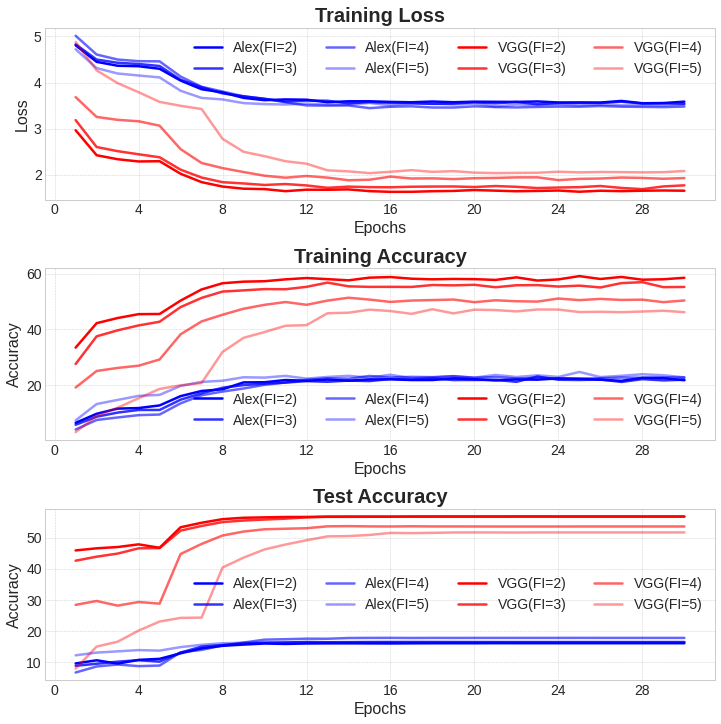

In [51]:
# losses_alex_li, train_accuracies_alex_li, test_accuracies_alex_li

# losses_vgg_li, train_accuracies_vgg_li, test_accuracies_vgg_li

# losses_res_li, train_accuracies_res_li, test_accuracies_res_li

# training_losses_res, train_accuracies_res_fth, test_accuracies_res_fth

# losses_goo_li, train_accuracies_goo_li, test_accuracies_goo_li

# training_losses_googlenet, train_accuracies_googlenet_ft, test_accuracies_googlenet_ft

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

# Use a clean style
plt.style.use('seaborn-whitegrid')

# Create the main figure
fig, axarr = plt.subplots(3, 1, figsize=(12, 12))

# Plot training loss
# FI stands for frozen index
# axarr[0].plot(range(1, len(losses_alex_li) + 1), losses_alex_li, label='Training Loss', color='blue', linewidth=2)
axarr[0].plot(range(1, len(training_losses_alex_2) + 1), training_losses_alex_2, label='Alex(FI=2)', color='blue', linewidth=2.5, alpha = 1)
axarr[0].plot(range(1, len(training_losses_alex_3) + 1), training_losses_alex_3, label='Alex(FI=3)', color='blue', linewidth=2.5, alpha = 0.8)
axarr[0].plot(range(1, len(training_losses_alex_4) + 1), training_losses_alex_4, label='Alex(FI=4)', color='blue', linewidth=2.5, alpha = 0.6)
axarr[0].plot(range(1, len(training_losses_alex_5) + 1), training_losses_alex_5, label='Alex(FI=5)', color='blue', linewidth=2.5, alpha = 0.4)
axarr[0].plot(range(1, len(training_losses_vgg_2) + 1), training_losses_vgg_2, label='VGG(FI=2)',color='red', linewidth=2.5, alpha = 1)
axarr[0].plot(range(1, len(training_losses_vgg_3) + 1), training_losses_vgg_3, label='VGG(FI=3)', color='red', linewidth=2.5, alpha = 0.8)
axarr[0].plot(range(1, len(training_losses_vgg_4) + 1), training_losses_vgg_4, label='VGG(FI=4)', color='red', linewidth=2.5, alpha = 0.6)
axarr[0].plot(range(1, len(training_losses_vgg_5) + 1), training_losses_vgg_5, label='VGG(FI=5)', color='red', linewidth=2.5, alpha = 0.4)
# axarr[0].plot(range(1, len(training_losses_vgg_6) + 1), training_losses_vgg_6, label='VGG(FI=6)', color='red', linewidth=2.5, alpha = 0.2)
axarr[0].set_title("Training Loss", fontsize=20, weight='bold')
axarr[0].set_xlabel("Epochs", fontsize=16)
axarr[0].set_ylabel("Loss", fontsize=16)
axarr[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[0].legend(loc='upper right', fontsize=14, ncol=4)
axarr[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[0].tick_params(axis='both', which='major', labelsize=14)

# Plot training and test accuracy
# axarr[1].plot(range(1, len(train_accuracies_res_li) + 1), train_accuracies_res_li, label='Training Accuracy', color='green', linewidth=2)
axarr[1].plot(range(1, len(train_accuracies_alex_fth_2) + 1), train_accuracies_alex_fth_2, label='Alex(FI=2)', color='blue', linewidth=2.5, alpha=1)
axarr[1].plot(range(1, len(train_accuracies_alex_fth_3) + 1), train_accuracies_alex_fth_3, label='Alex(FI=3)', color='blue', linewidth=2.5, alpha=0.8)
axarr[1].plot(range(1, len(train_accuracies_alex_fth_4) + 1), train_accuracies_alex_fth_4, label='Alex(FI=4)', color='blue', linewidth=2.5, alpha=0.6)
axarr[1].plot(range(1, len(train_accuracies_alex_fth_5) + 1), train_accuracies_alex_fth_5, label='Alex(FI=5)', color='blue', linewidth=2.5, alpha=0.4)
axarr[1].plot(range(1, len(train_accuracies_vgg_fth_2) + 1), train_accuracies_vgg_fth_2, label='VGG(FI=2)', color='red', linewidth=2.5, alpha=1)
axarr[1].plot(range(1, len(train_accuracies_vgg_fth_3) + 1), train_accuracies_vgg_fth_3, label='VGG(FI=3)', color='red', linewidth=2.5, alpha=0.8)
axarr[1].plot(range(1, len(train_accuracies_vgg_fth_4) + 1), train_accuracies_vgg_fth_4, label='VGG(FI=4)', color='red', linewidth=2.5, alpha=0.6)
axarr[1].plot(range(1, len(train_accuracies_vgg_fth_5) + 1), train_accuracies_vgg_fth_5, label='VGG(FI=5)', color='red', linewidth=2.5, alpha=0.4)
axarr[1].set_title("Training Accuracy", fontsize=20, weight='bold')
axarr[1].set_xlabel("Epochs", fontsize=16)
axarr[1].set_ylabel("Accuracy", fontsize=16)
axarr[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[1].legend(loc='lower right', fontsize=14, ncol=4)
axarr[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[1].tick_params(axis='both', which='major', labelsize=14)


# axarr[2].plot(range(1, len(test_accuracies_res_li) + 1), test_accuracies_res_li, label='Test Accuracy', color='red', linewidth=2)
axarr[2].plot(range(1, len(test_accuracies_alex_fth_2) + 1), test_accuracies_alex_fth_2, label='Alex(FI=2)', color='blue', linewidth=2.5, alpha=1)
axarr[2].plot(range(1, len(test_accuracies_alex_fth_3) + 1), test_accuracies_alex_fth_3, label='Alex(FI=3)', color='blue', linewidth=2.5, alpha=0.8)
axarr[2].plot(range(1, len(test_accuracies_alex_fth_4) + 1), test_accuracies_alex_fth_4, label='Alex(FI=4)', color='blue', linewidth=2.5, alpha=0.6)
axarr[2].plot(range(1, len(test_accuracies_alex_fth_5) + 1), test_accuracies_alex_fth_5, label='Alex(FI=5)', color='blue', linewidth=2.5, alpha=0.4)
axarr[2].plot(range(1, len(test_accuracies_vgg_fth_2) + 1), test_accuracies_vgg_fth_2, label='VGG(FI=2)', color='red', linewidth=2.5, alpha=1)
axarr[2].plot(range(1, len(test_accuracies_vgg_fth_3) + 1), test_accuracies_vgg_fth_3, label='VGG(FI=3)', color='red', linewidth=2.5, alpha=0.8)
axarr[2].plot(range(1, len(test_accuracies_vgg_fth_4) + 1), test_accuracies_vgg_fth_4, label='VGG(FI=4)', color='red', linewidth=2.5, alpha=0.6)
axarr[2].plot(range(1, len(test_accuracies_vgg_fth_5) + 1), test_accuracies_vgg_fth_5, label='VGG(FI=5)', color='red', linewidth=2.5, alpha=0.4)
axarr[2].set_title("Test Accuracy", fontsize=20, weight='bold')
axarr[2].set_xlabel("Epochs", fontsize=16)
axarr[2].set_ylabel("Accuracy", fontsize=16)
axarr[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[2].legend(loc='center right', fontsize=14, ncol=4)
axarr[2].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[2].tick_params(axis='both', which='major', labelsize=14)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)  # Adjust vertical spacing

# Show the plot
plt.show()


In [43]:
train_accuracies_goo_li = [accuracy * 100 for accuracy in train_accuracies_goo_li]
train_accuracies_res_li = [accuracy * 100 for accuracy in train_accuracies_res_li]
test_accuracies_goo_li = [accuracy * 100 for accuracy in test_accuracies_goo_li]
test_accuracies_res_li = [accuracy * 100 for accuracy in test_accuracies_res_li]

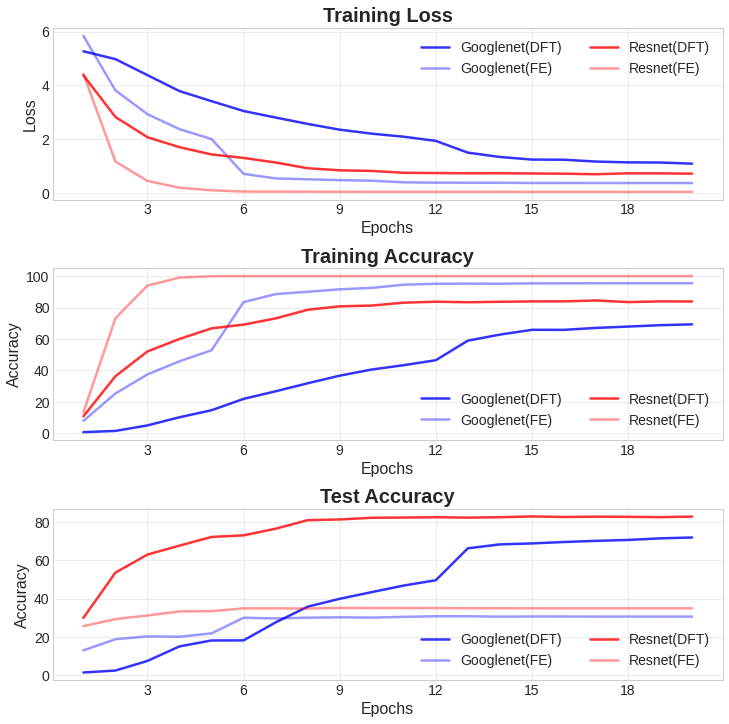

In [44]:
# losses_alex_li, train_accuracies_alex_li, test_accuracies_alex_li
# losses_vgg_li, train_accuracies_vgg_li, test_accuracies_vgg_li

# Use a clean style
plt.style.use('seaborn-whitegrid')

# Create the main figure
fig, axarr = plt.subplots(3, 1, figsize=(12, 12))

# Plot training loss
axarr[0].plot(range(1, len(training_losses_googlenet) + 1), training_losses_googlenet, label='Googlenet(DFT)', color='blue', linewidth=2.5, alpha=0.8)
axarr[0].plot(range(1, len(losses_goo_li) + 1), losses_goo_li, label='Googlenet(FE)', color='blue', linewidth=2.5, alpha=0.4)
axarr[0].plot(range(1, len(training_losses_res) + 1), training_losses_res, label='Resnet(DFT)', color='red', linewidth=2.5,alpha=0.8)
axarr[0].plot(range(1, len(losses_res_li) + 1), losses_res_li, label='Resnet(FE)', color='red', linewidth=2.5,alpha=0.4)
axarr[0].set_title("Training Loss", fontsize=20, weight='bold')
axarr[0].set_xlabel("Epochs", fontsize=16)
axarr[0].set_ylabel("Loss", fontsize=16)
axarr[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[0].legend(loc='upper right', fontsize=14, ncol=2)
axarr[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[0].tick_params(axis='both', which='major', labelsize=14)

# Plot training and test accuracy
axarr[1].plot(range(1, len(train_accuracies_googlenet_ft) + 1), train_accuracies_googlenet_ft, label='Googlenet(DFT)',color='blue', linewidth=2.5,alpha=0.8)
axarr[1].plot(range(1, len(train_accuracies_goo_li) + 1), train_accuracies_goo_li, label='Googlenet(FE)', color='blue', linewidth=2.5,alpha=0.4)
axarr[1].plot(range(1, len(train_accuracies_res_fth) + 1), train_accuracies_res_fth, label='Resnet(DFT)',color='red', linewidth=2.5,alpha=0.8)
axarr[1].plot(range(1, len(train_accuracies_res_li) + 1), train_accuracies_res_li, label='Resnet(FE)', color='red', linewidth=2.5,alpha=0.4)
axarr[1].set_title("Training Accuracy", fontsize=20, weight='bold')
axarr[1].set_xlabel("Epochs", fontsize=16)
axarr[1].set_ylabel("Accuracy", fontsize=16)
axarr[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[1].legend(loc='lower right', fontsize=14, ncol=2)
axarr[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[1].tick_params(axis='both', which='major', labelsize=14)


axarr[2].plot(range(1, len(test_accuracies_googlenet_ft) + 1), test_accuracies_googlenet_ft, label='Googlenet(DFT)',color='blue',linewidth=2.5,alpha=0.8)
axarr[2].plot(range(1, len(test_accuracies_goo_li) + 1), test_accuracies_goo_li, label='Googlenet(FE)',color='blue',linewidth=2.5,alpha=0.4)
axarr[2].plot(range(1, len(test_accuracies_res_fth) + 1), test_accuracies_res_fth, label='Resnet(DFT)',color='red', linewidth=2.5,alpha=0.8)
axarr[2].plot(range(1, len(test_accuracies_res_li) + 1), test_accuracies_res_li, label='Resnet(FE)',color='red', linewidth=2.5,alpha=0.4)
axarr[2].set_title("Test Accuracy", fontsize=20, weight='bold')
axarr[2].set_xlabel("Epochs", fontsize=16)
axarr[2].set_ylabel("Accuracy", fontsize=16)
axarr[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axarr[2].legend(loc='lower right', fontsize=14, ncol=2)
axarr[2].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[2].tick_params(axis='both', which='major', labelsize=14)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)  # Adjust vertical spacing

# Show the plot
plt.show()

## 6.2 Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


Prediction for Rolls-Royce Ghost Sedan 2012 is:
1: Rolls-Royce Ghost Sedan 2012 (confidence: 0.8699)
2: Rolls-Royce Phantom Sedan 2012 (confidence: 0.0786)
3: Rolls-Royce Phantom Drophead Coupe Convertible 2012 (confidence: 0.0411)
4: Dodge Ram Pickup 3500 Crew Cab 2010 (confidence: 0.0019)
5: Bentley Mulsanne Sedan 2011 (confidence: 0.0006)


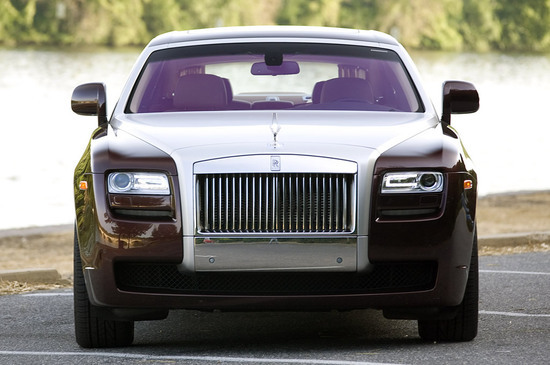

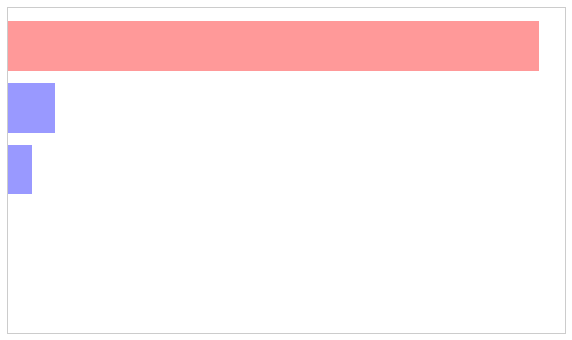

In [45]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from IPython.display import display
import matplotlib.pyplot as plt

# Function to find class indices
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

# Set dataset directory
dataset_dir = "car_data/car_data/"
classes, c_to_idx = find_classes(dataset_dir + "train")

# Transforms for the input image
loader = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Function to predict the top 5 classes and generate the bar plot
def predict_and_plot(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=False)
    image = image.unsqueeze(0)
    image = image.cuda()

    # Load the model (change the model name here)
    model = classifier_res_fth

    # Switch the model to evaluation mode
    model.eval()

    # Get model output
    output = model(image)

    # Get the top 5 predictions
    topk_confidences, topk_indices = torch.topk(F.softmax(output, dim=1), 5)

    # Extract the actual class name from the image path
    actual_class_name = os.path.basename(os.path.dirname(image_path))

    # Prepare data for plotting
    topk_classes = [classes[idx] for idx in topk_indices[0]]
    topk_confidences = topk_confidences[0].tolist()

    # Print the predictions
    print(f"Prediction for {actual_class_name} is:")
    for i in range(len(topk_classes)):
        print(f"{i+1}: {topk_classes[i]} (confidence: {topk_confidences[i]:.4f})")

    # Display the image
    display(Image.open(image_path))

    # Plotting the bar chart
    colors = ['blue' if cls != actual_class_name else 'red' for cls in topk_classes]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(topk_confidences)), topk_confidences, color=colors, alpha=0.4)

    # Hide x-axis labels
    plt.xticks([])

    plt.gca().invert_yaxis()  # Highest confidence at the top

    # Hide y-axis labels (class names) and title
    plt.yticks([])
    plt.title('')

    plt.show()

# Example usage
image_path = dataset_dir + "test/Rolls-Royce Ghost Sedan 2012/01505.jpg"
predict_and_plot(image_path)



## 6.3 Similarity analysis

In this part we tend to evaluate the performance of our best model in a visual and intuitive way - similarity analysis. We will randomly pick 5 test data points. Then we will extract feature vectors in the last hidden layer. And we will calculate the K-neighbor-nearst training data points and compare them visually.

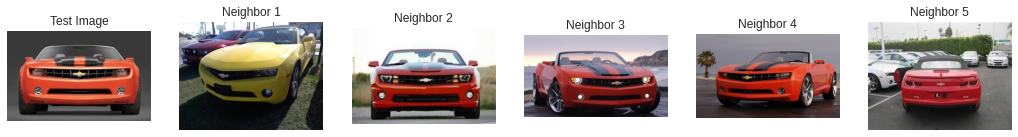

In [46]:
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.img_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            img_names = os.listdir(cls_dir)
            self.img_paths.extend([(os.path.join(cls_dir, img), cls) for img in img_names])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, cls = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, cls, os.path.basename(img_path)  # Return image, class, and filename

# Set dataset directory and test image path
dataset_dir = "car_data/car_data/"
image_path = dataset_dir + "test/Chevrolet Camaro Convertible 2012/02765.jpg"

# Load and preprocess the test image
loader = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_image = Image.open(image_path)
test_image = loader(test_image).unsqueeze(0).cuda()  # Move to GPU

# Load the trained ResNet50 model
model_ft = classifier_res_fth.cuda()  # Move to GPU
# Remove the final linear layer (classification layer)
model_ft = torch.nn.Sequential(*list(model_ft.children())[:-1])
model_ft.eval()

# Function to extract features
def extract_features(model, input_image):
    with torch.no_grad():
        features = model(input_image)
    return features.squeeze().cpu().numpy()  # Move to CPU for compatibility with scikit-learn

# Extract features from the test image
test_features = extract_features(model_ft, test_image)

# Create custom dataset for training data
train_dataset = CustomDataset(root_dir=os.path.join(dataset_dir, "train"), transform=loader)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Load training data points and extract features
train_features = []
train_filenames = []  # Store filenames
train_classes = []  # Store classes
for batch_images, batch_classes, batch_filenames in trainloader:
    batch_features = extract_features(model_ft, batch_images.cuda())  # Move to GPU
    train_features.append(batch_features)
    train_filenames.extend(batch_filenames)
    train_classes.extend(batch_classes)
train_features = np.concatenate(train_features)

# Calculate distances between test features and training features
distances = euclidean_distances(test_features.reshape(1, -1), train_features)

# Find the indices of the 5 nearest neighbors
nearest_indices = np.argsort(distances)[0][:5]

# Get the filenames and classes of the nearest neighbors
nearest_filenames = [train_filenames[idx] for idx in nearest_indices]
nearest_classes = [train_classes[idx] for idx in nearest_indices]

# Display the test image first
plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)  # Test image in the first subplot
test_image_disp = Image.open(image_path)
plt.imshow(test_image_disp)
plt.axis('off')
plt.title("Test Image")

# Display the images of the 5 nearest neighbors
for i, (filename, cls) in enumerate(zip(nearest_filenames, nearest_classes)):
    image = Image.open(os.path.join(dataset_dir, "train", cls, filename))
    plt.subplot(1, 6, i + 2)  # Neighbors in the following subplots
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Neighbor {i+1}")

plt.show()

## 6.4 Classification report

| Model    | train_acc| test_acc |
|----------|----------|----------|
| Alex last linear |0.9984 |0.2480 |
| Alex last SVM |0.9985 |0.3033 |
| Alex last ft4 | 0.9754|0.22 |
| Alex last ft3 |0.7388 | 0.21|
| Alex last ft2 |0.7725 |0.20 |
| Alex last ft5 |0.8074 |0.20 |
| VGG last linear |0.9985 |0.2746 |
| VGG last ft5 |0.9776 |0.45 |
| VGG last ft4 |0.9805 |0.39 |
| VGG last ft3 |0.9888 |0.39 |
| VGG last ft2 |0.9915 |0.39 |
| VGG last ft6 |0.9932 |0.40 |
| V1 resnet 50  last linear | 0.9741   | 0.4635   |
| V1 resnet 50  last two linear   | 0.9747   | 0.4674   |
| V1 resnet 50  last SVM   | 0.9985   | 0.4446   |
| V1 resnet 50  last fine-tune   | 0.9964   | 0.7830   |
| V2 resnet 101  last fine-tune   | 0.9957   | 0.8215   |
| V1 Googlenet  last linear   | 0.9682   | 0.4095   |
| V1 Googlenet  last SVM   | 0.9985   | 0.3776  |
| V1 Googlenet  last fine-tune   | 0.5779   | 0.3216   |
| V2 resnet 50  last linear   | 0.9985   | 0.4823   |
| V2 resnet 50  last two linear   | 0.9985   | 0.4861   |
| V2 resnet 50  last SVM   | 0.9985   | 0.4517   |
| V2 resnet 50  last fine-tune   | 0.9938   | 0.7472   |